Copyright 2020 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Inverse Optimal Control

Discrete tabular experiments for evaluating imitation learning algorithms in the inverse optimal control setting, as shown in Section 5.1 and Appendix M of the paper.

In [4]:
# @title Setup and define MDPs
from typing import Optional, Tuple

from IPython.display import HTML, display
import jax
from jax import config
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import tabulate

config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

EPS = 1e-6  # avoid nans
# The 'Dense' environment in the paper
# SPARSE_INITIAL_STATES = False
# EASY_REWARD = True
# The 'Sparse' environment in the paper
SPARSE_INITIAL_STATES = True
EASY_REWARD = False

%matplotlib inline

def softmax(values: jax.Array, temperature: float, prior: jax.Array) -> jax.Array:
  """Softmax operation with temperature and prior."""
  log_values = values / temperature + jnp.log(prior)
  return jax.nn.softmax(log_values, axis=1)

def soft_policy_iteration(reward: jax.Array, transition: jax.Array,
                          initial: jax.Array,  prior_policy: jax.Array,
                          alpha: float, gamma: float, n_iters: int = 1000,
                          pi_init: Optional[jax.Array] = None,
                          q_init: Optional[jax.Array] = None
                         ) -> Tuple[jax.Array, jax.Array, jax.Array]:
  """Run soft policy iteration on a Markov decision process."""
  d_state, d_action, _ = transition.shape
  q = jnp.zeros((d_state, d_action)) if q_init is None else q_init
  pi = jnp.ones(((d_state, d_action))) / d_action if pi_init is None else pi_init

  def step(pi: jax.Array, q: jax.Array) -> Tuple[jax.Array, jax.Array, jax.Array]:
    pi_kl = jnp.sum(pi * (jnp.log(prior_policy) - jnp.log(EPS + pi)), axis=1)
    v = jnp.sum(q * pi, axis=1) + alpha * pi_kl
    q = reward + gamma * jnp.sum(transition * jnp.tile(v, (d_state, d_action, 1)), 2) + (1-gamma) * jnp.sum(initial * v)
    pi = softmax(q, alpha, prior_policy)
    return pi, q, v

  step = jax.jit(step)

  for _ in tqdm(range(n_iters)):
    pi, q, v = step(pi, q)
  return pi, q, v

def stationary_distribution(initial: jax.Array, transition: jax.Array, policy: jax.Array, discount: float, n_iters: int = 1000) -> jax.Array:
  """Compute the discounted stationary distribution of a policy."""
  distribution = initial

  def sim(distribution: jax.Array) -> Tuple[jax.Array, float]:
    distribution_ = discount * jnp.einsum("ijk,ij,i->k", transition, policy, distribution) + (1 - discount) * initial
    distribution_ = distribution_ / distribution_.sum()
    delta = jnp.abs(distribution_ - distribution).max()
    return distribution_, delta

  sim = jax.jit(sim)
  for _ in range(n_iters):
    distribution, delta = sim(distribution)
    if delta < 1e-4:
      break
  else:
    print("Didn't converge!")
  return distribution

def simulate(initial: jax.Array, transition: jax.Array, policy: jax.Array, absorbing_states: jax.Array, n_episodes: int) -> jax.Array:
  """Simulate a policy and return a dataset of trajectories."""
  t_max = 5_000
  key = jax.random.PRNGKey(0)
  d_state, d_action = policy.shape
  experience = np.zeros((t_max, d_state, d_action))
  state = jax.random.choice(key, jnp.arange(d_state), p=initial)
  n, t = 0, 0
  while n < n_episodes:
    _, key = jax.random.split(key)
    # act greedy
    action = jnp.argmax(policy[state])
    experience[t, state, action] = experience[t, state, action] + 1
    next_state_dist = transition[state, action, :]
    next_state = jax.random.choice(key, jnp.arange(d_state), p=next_state_dist)
    t += 1
    if state in absorbing_states:
      state = jax.random.choice(key, jnp.arange(d_state), p=initial)
      n += 1
    else:
      state = next_state
  return experience[:t, :, :]

d_action = 4
width = 10
discount = 0.95
gamma = discount
d_state = width * width
reward = jnp.zeros((d_state, d_action))

if EASY_REWARD:
  absorbing_state = [13 * width // 4,
                     15 * width // 4,
                     29 * width // 4,
                     31 * width // 4]
  for s in absorbing_state:
    reward = reward.at[s, :].set(1.)

else:  # sparse positive and negative
  reward = reward.at[-width, :].set(1. / (1 - discount))
  reward = reward.at[3 * width, :].set(-1. / (1 - discount))
  absorbing_state = [d_state - width,]

policy_eval = lambda eval_policy, state_dist: (reward * (jnp.diag(state_dist) @ eval_policy)).sum()

def make_dynamics(width: int, d_state: int, d_action: int, initial_idxs: jax.Array, windy: bool) -> jax.Array:
  """Construct the state transition matrix."""
  transition_matrix = jnp.zeros((d_state, d_action, d_state))
  clamp = lambda coord: max(min(coord, width - 1), 0)
  idx_to_coord = lambda idx: (i % width, i // width)
  coord_to_idx = lambda x, y:  clamp(y) * width + clamp(x)
  for i in range(d_state):
    x, y = idx_to_coord(i)
    next_states = jnp.array(list(map(coord_to_idx, [x+1, x-1, x, x], [y, y, y+1, y-1])))
    for j, k in zip(jnp.arange(d_action), next_states):
      if i not in absorbing_state:
        transition_matrix = transition_matrix.at[i, j, k].set(1.)
      else: # state is absorbing
        transition_matrix = transition_matrix.at[i, j, initial_idxs].set(1.)
    if windy and i != (d_state - width):
      disturance_idx = coord_to_idx(x+1, y)
      for j in range(d_action):
        transition_matrix = transition_matrix.at[i, j, disturance_idx].set(1.0)
  transition_matrix = transition_matrix / transition_matrix.sum(axis=2, keepdims=True)
  return transition_matrix

if SPARSE_INITIAL_STATES:
  initial_idxs = jnp.zeros((1,)).astype(jnp.int32)
  initial = jnp.zeros((d_state))
  initial = initial.at[0].set(1.)
else:
  initial_idxs = jnp.arange(d_state)
  initial = jnp.ones((d_state))

initial = initial / initial.sum()

transition_matrix = make_dynamics(width, d_state, d_action, initial_idxs, windy=False)

windy_transition_matrix = make_dynamics(width, d_state, d_action, initial_idxs, windy=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 7700.96it/s]


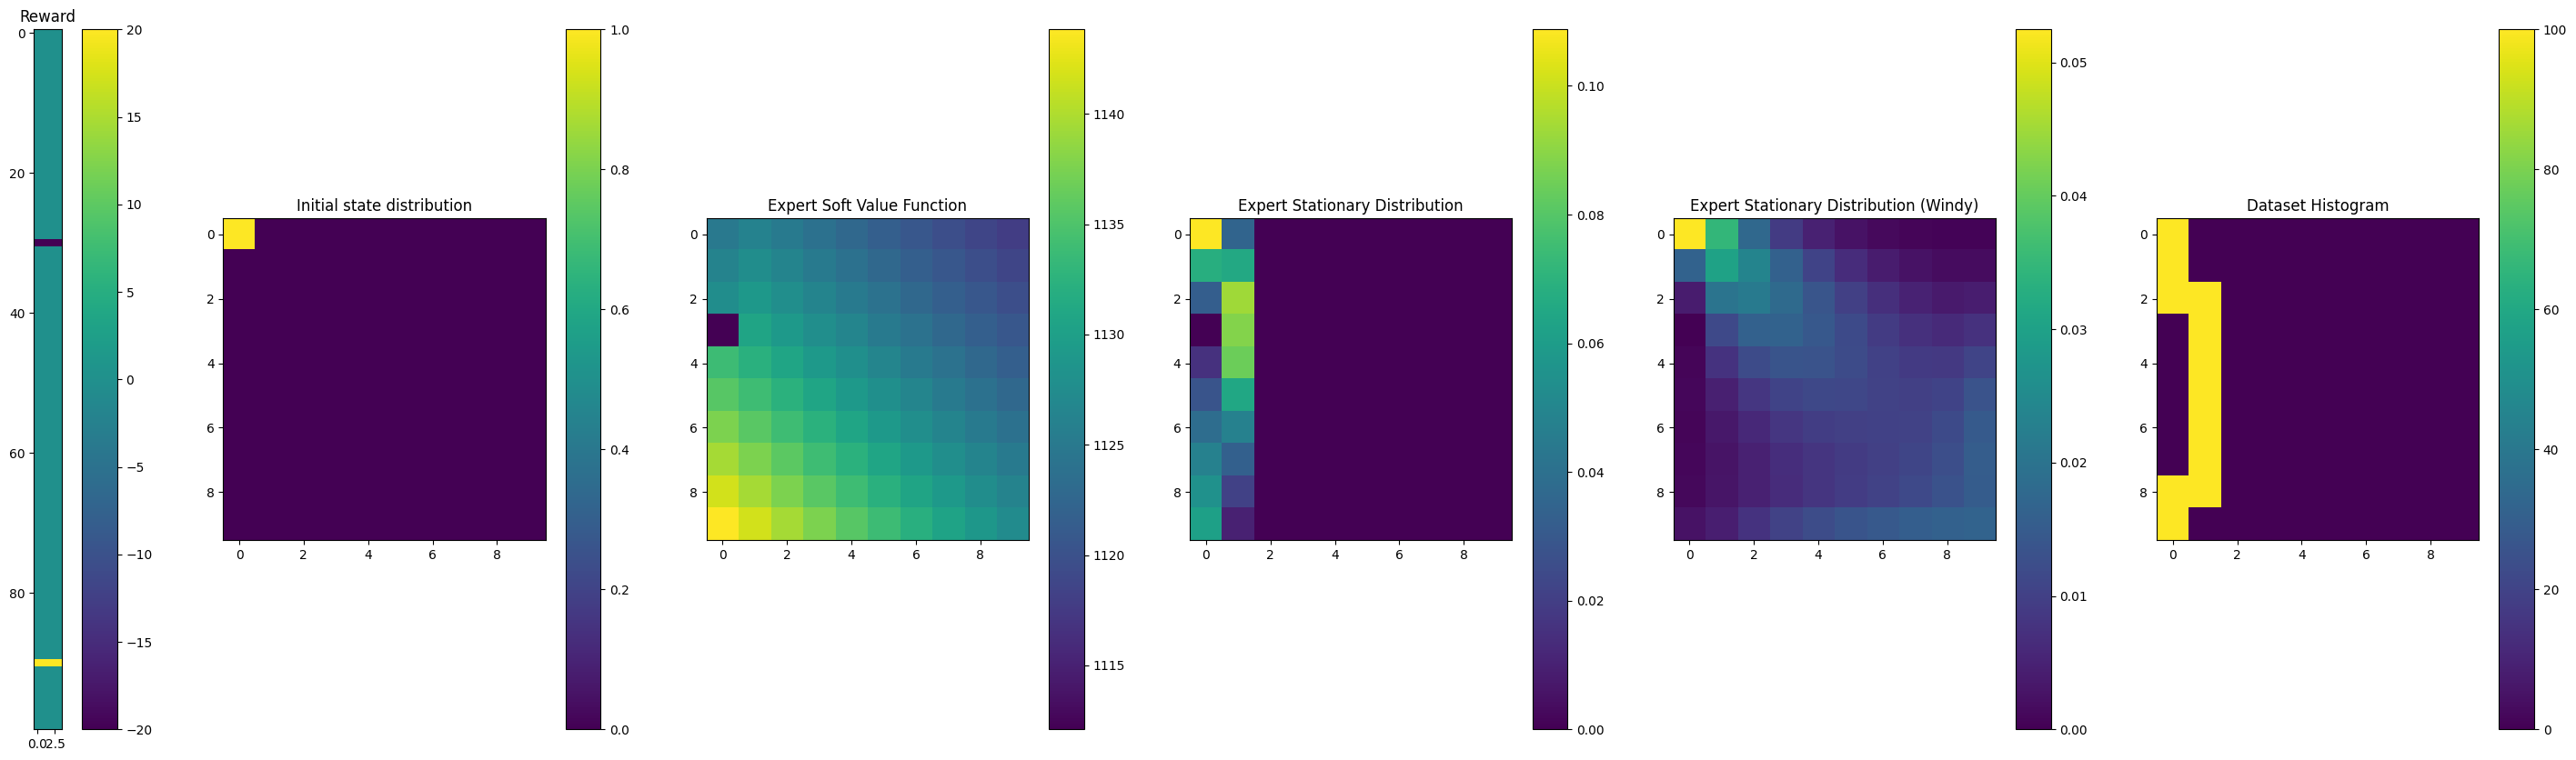

In [5]:
# @title Expert (SPI)

expert_alpha = 0.1
prior_policy = jnp.ones((d_state, d_action)) / d_action
expert_pi, expert_q, expert_v = soft_policy_iteration(reward, transition_matrix, initial, prior_policy, alpha=expert_alpha, gamma=discount)
expert_rho = stationary_distribution(initial, transition_matrix, expert_pi, discount)
expert_windy_rho = stationary_distribution(initial, windy_transition_matrix, expert_pi, discount)

experience = simulate(initial, transition_matrix, expert_pi, absorbing_state, n_episodes=100)
expert_counts = experience.sum(0)
expert_distribution = expert_counts / expert_counts.sum(keepdims=True)

fig, ax = plt.subplots(1, 6, figsize=(40, 10))
ax[0].set_title("Reward")
r = ax[0].imshow(reward)
plt.colorbar(r, ax=ax[0])

ax[1].set_title("Initial state distribution")
mu_ = ax[1].imshow(initial.reshape((width, width)))
plt.colorbar(mu_, ax=ax[1])

ax[2].set_title("Expert Soft Value Function")
v_ = ax[2].imshow(expert_v.reshape((width, width)))
plt.colorbar(v_, ax=ax[2])

ax[3].set_title("Expert Stationary Distribution")
rho_ = ax[3].imshow(expert_rho.reshape((width, width)))
plt.colorbar(rho_, ax=ax[3])

ax_ = ax[4]
ax_.set_title("Expert Stationary Distribution (Windy)")
fig = ax_.imshow(expert_windy_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax[5].set_title("Dataset Histogram")
rho_ = ax[5].imshow(experience.sum(0).sum(1).reshape((width, width)))
plt.colorbar(rho_, ax=ax[5])

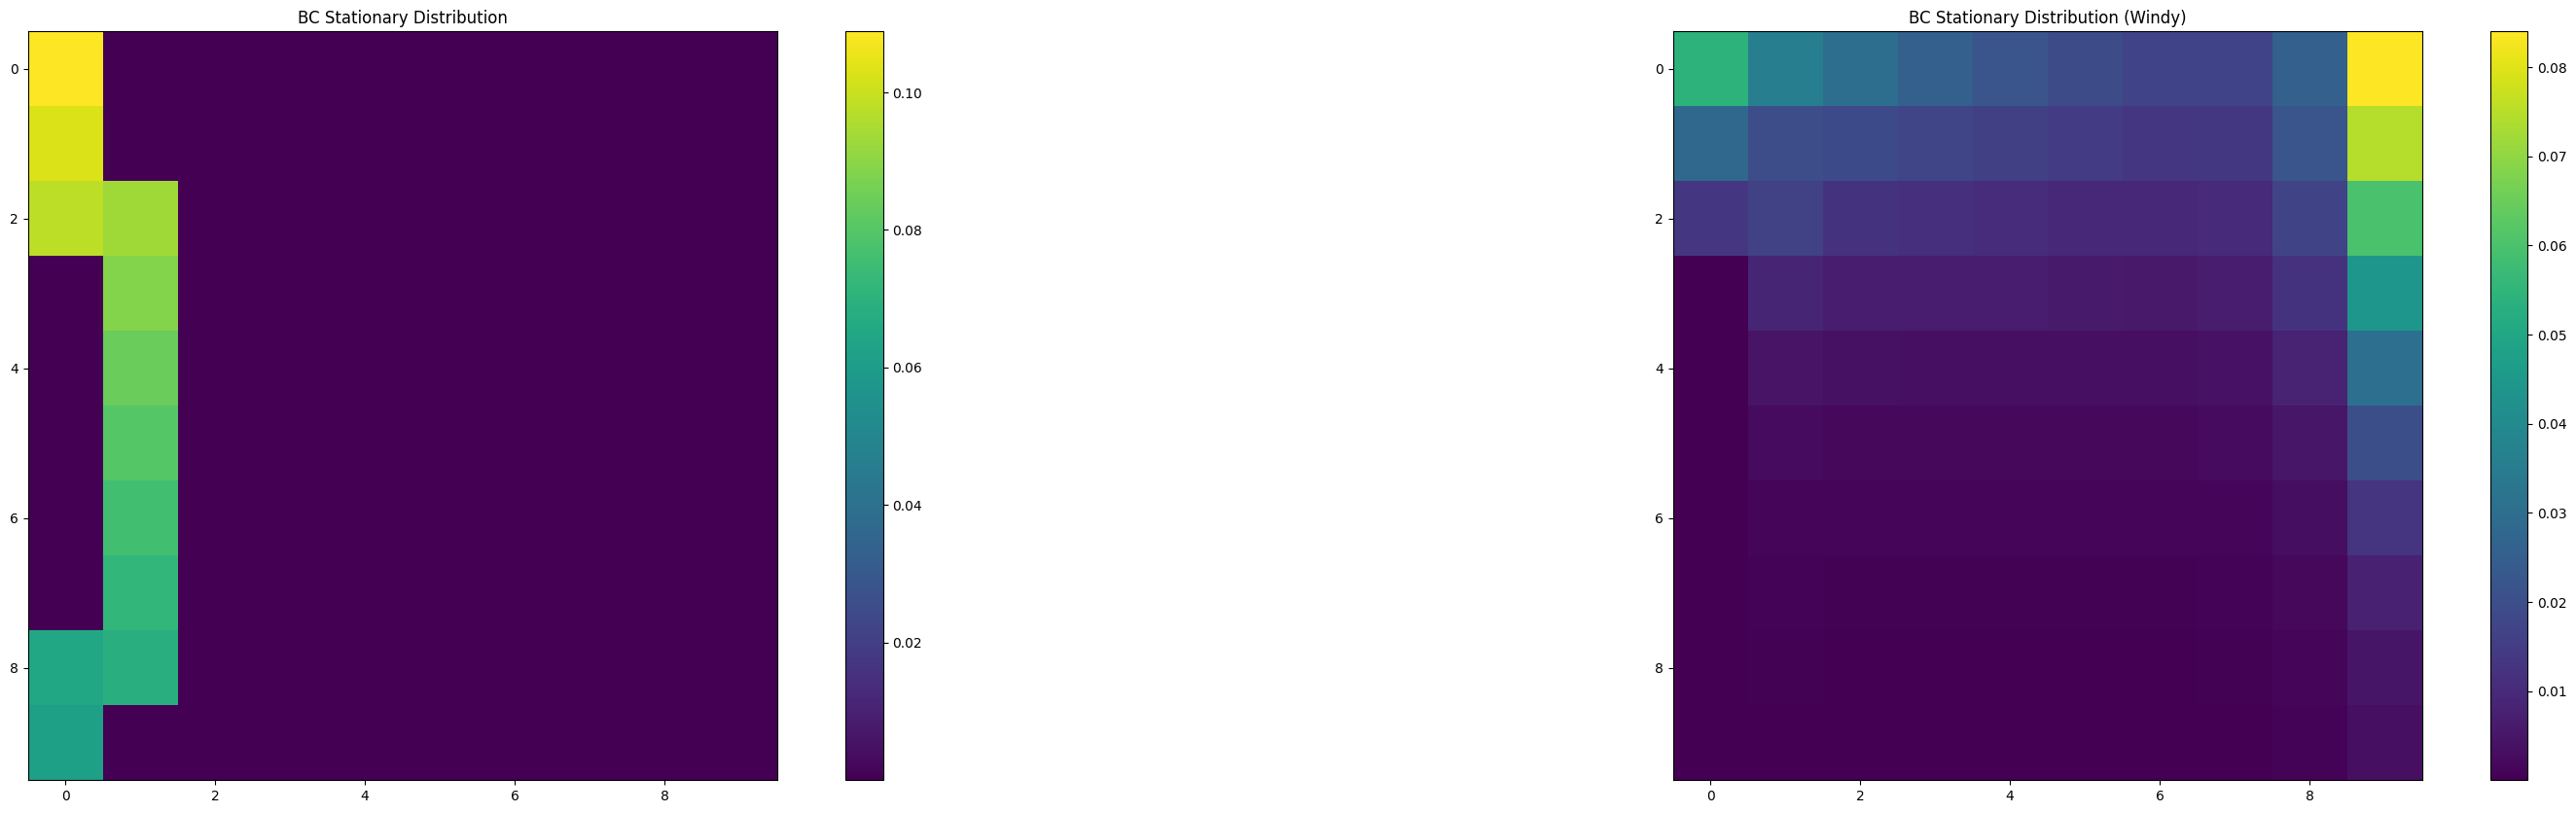

In [6]:
# @title Behavoural Cloning (BC)

def fit_policy(data, prior):
  state_action_counts = data.sum(0)
  unnormalised = state_action_counts + jnp.log(prior)
  return jnp.exp(unnormalised - logsumexp(unnormalised, axis=1, keepdims=True))

bc_pi = fit_policy(experience, prior_policy) + EPS
bc_rho = stationary_distribution(initial, transition_matrix, bc_pi, discount)
bc_windy_rho = stationary_distribution(initial, windy_transition_matrix, bc_pi, discount)

fig, ax = plt.subplots(1, 2, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("BC Stationary Distribution")
fig = ax_.imshow(bc_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("BC Stationary Distribution (Windy)")
fig = ax_.imshow(bc_windy_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10451.40it/s]


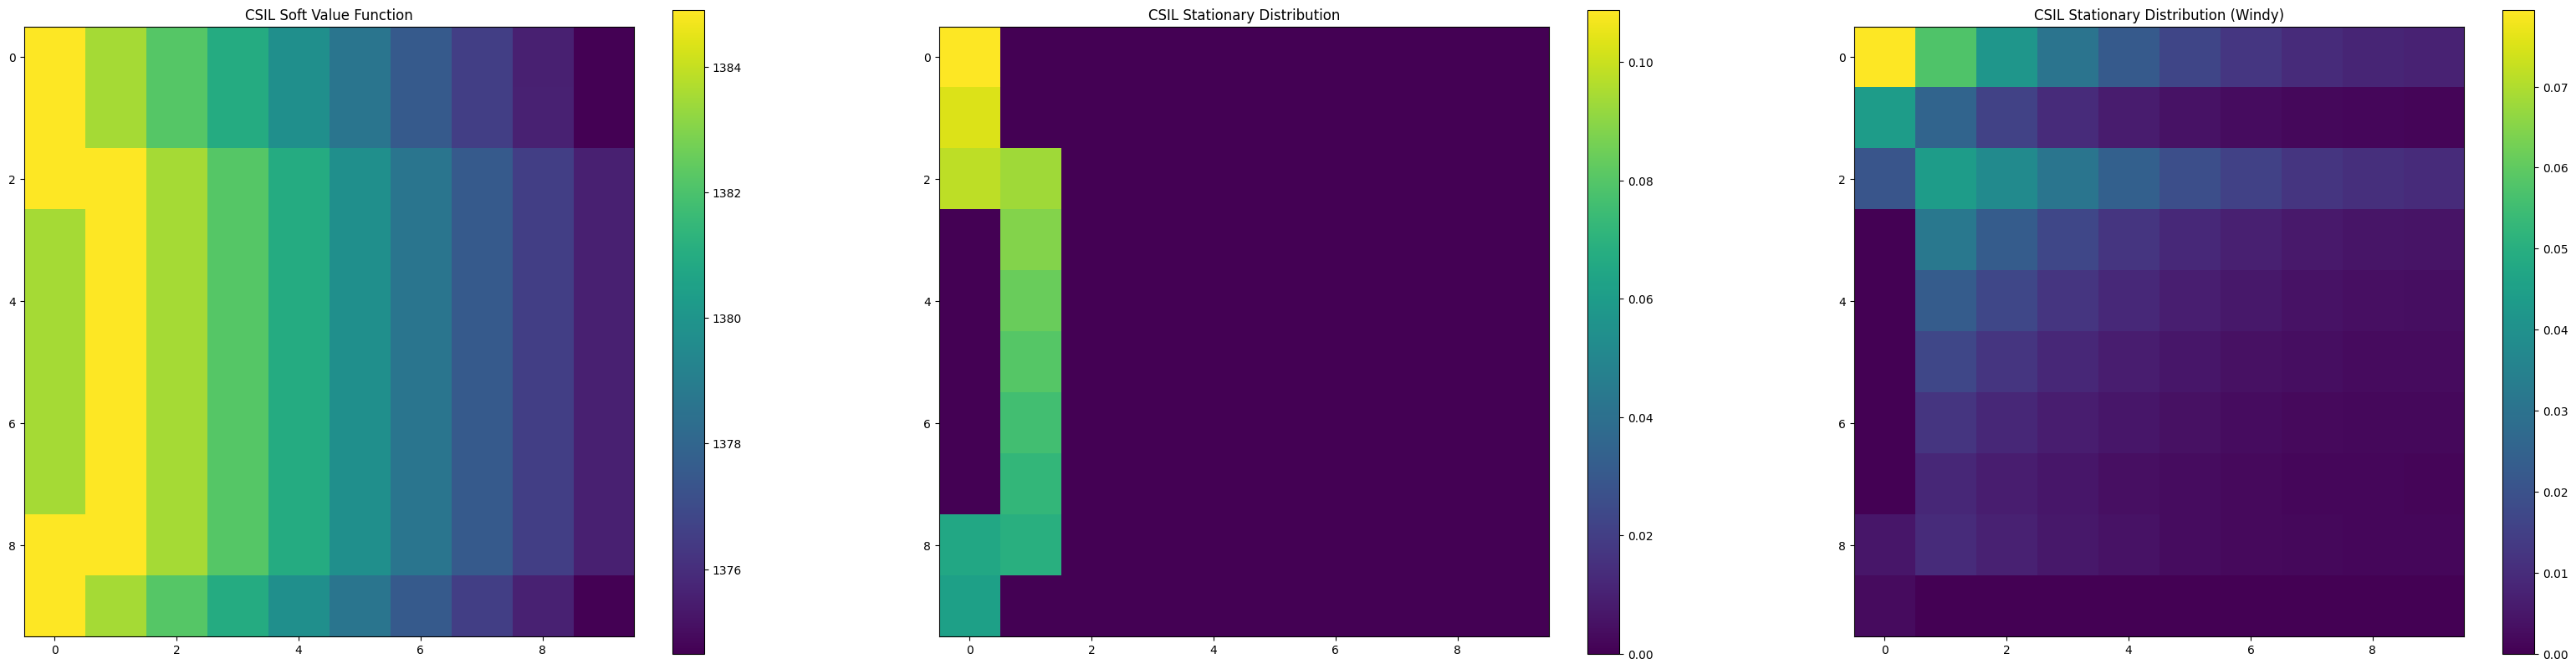

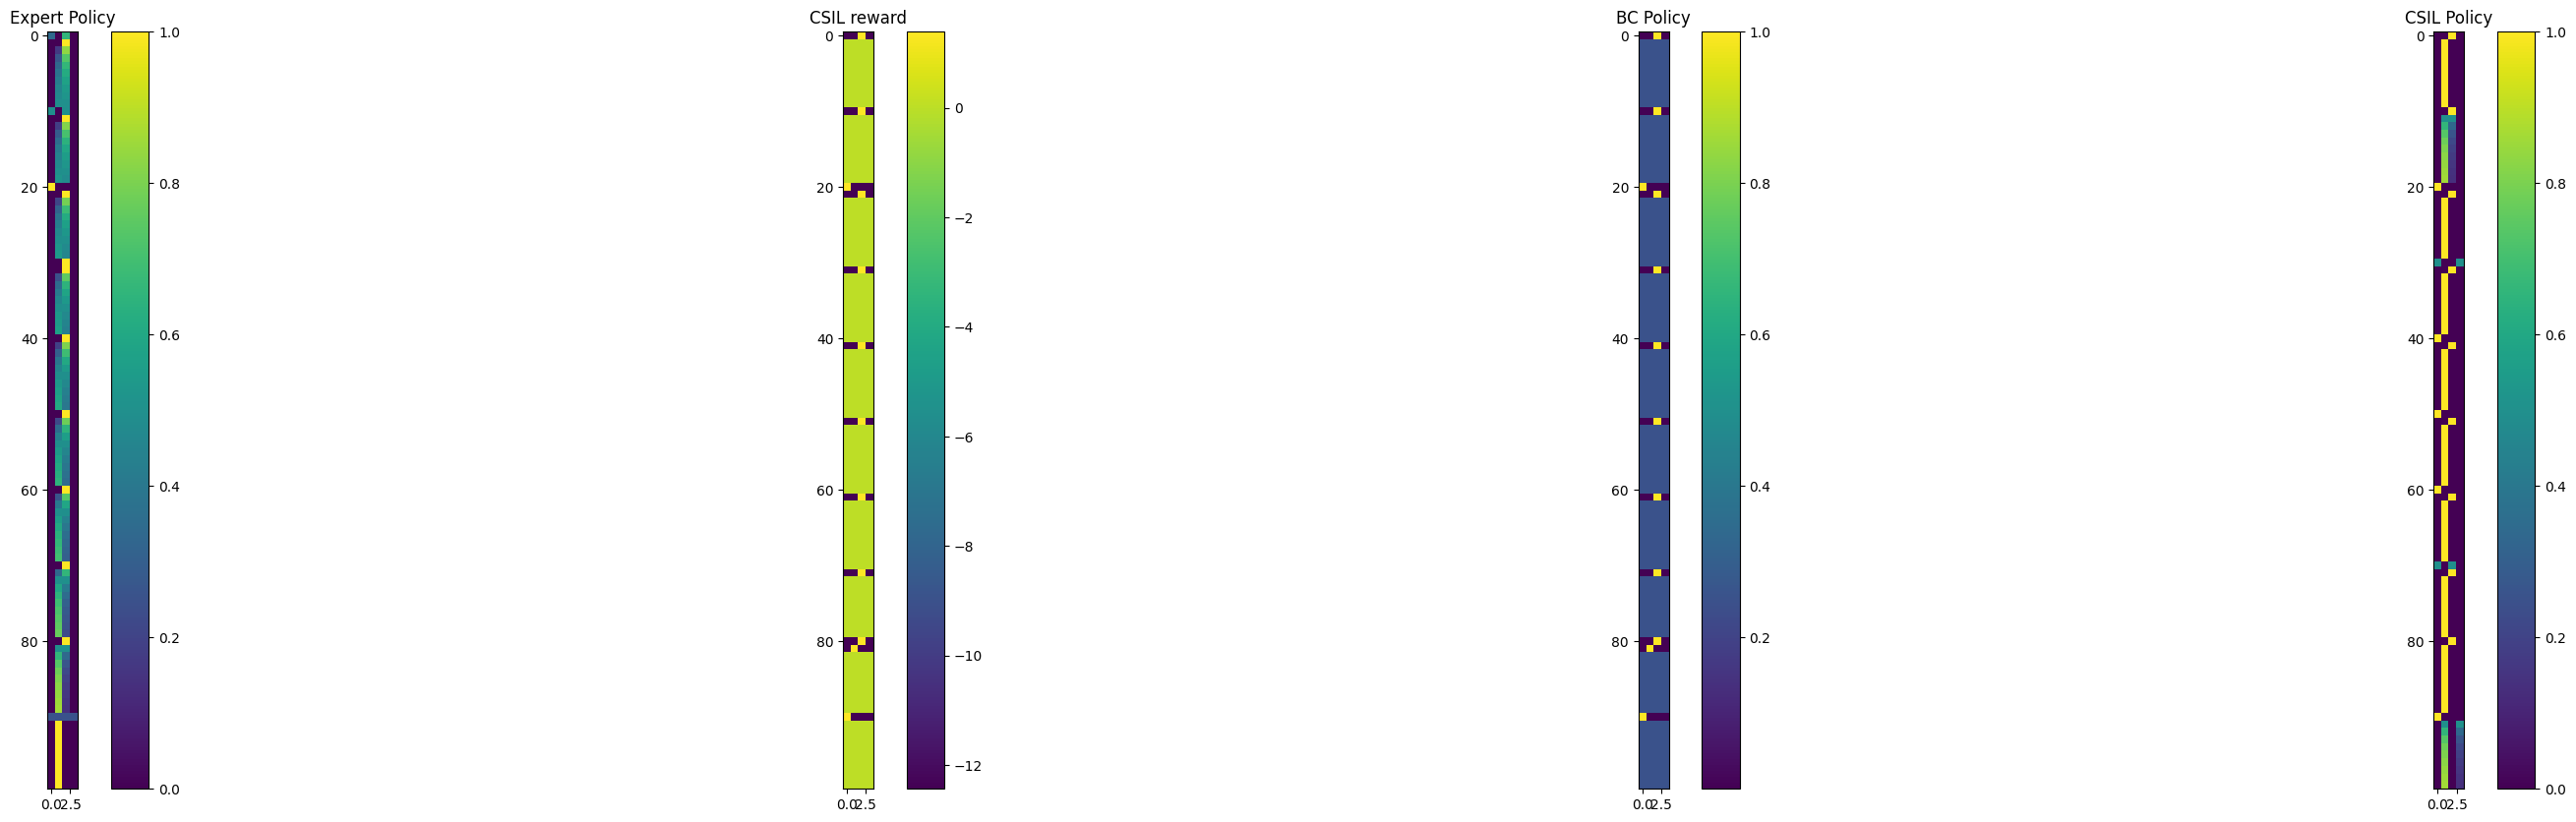

In [7]:
#@title Coherent Soft Imitation Learning (CSIL)
log_ratio = jnp.log(bc_pi) - jnp.log(prior_policy)
csil_alpha = 1.
csil_reward = csil_alpha  * log_ratio

csil_alpha = 1e-3
csil_pi, csil_q, csil_v = soft_policy_iteration(csil_reward, transition_matrix, initial,  prior_policy, alpha=csil_alpha, gamma=discount, pi_init=bc_pi, q_init=csil_reward)
rho_pcirl = stationary_distribution(initial, transition_matrix, csil_pi, discount)
windy_rho_pcirl = stationary_distribution(initial, windy_transition_matrix, csil_pi, discount)

csil_R_det = policy_eval(csil_pi, rho_pcirl)
csil_R_windy = policy_eval(csil_pi, windy_rho_pcirl)

fig, ax = plt.subplots(1, 3, figsize=(40, 10))

ax_ = ax[0]
ax_.set_title("CSIL Soft Value Function")
fig = ax_.imshow(csil_v.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("CSIL Stationary Distribution")
fig = ax_.imshow(rho_pcirl.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("CSIL Stationary Distribution (Windy)")
fig = ax_.imshow(windy_rho_pcirl.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("Expert Policy")
fig = ax_.imshow(expert_pi)
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("CSIL reward")
fig = ax_.imshow(csil_reward)
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("BC Policy")
fig = ax_.imshow(bc_pi)
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("CSIL Policy")
fig = ax_.imshow(csil_pi)
plt.colorbar(fig, ax=ax_)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 10149.19it/s]


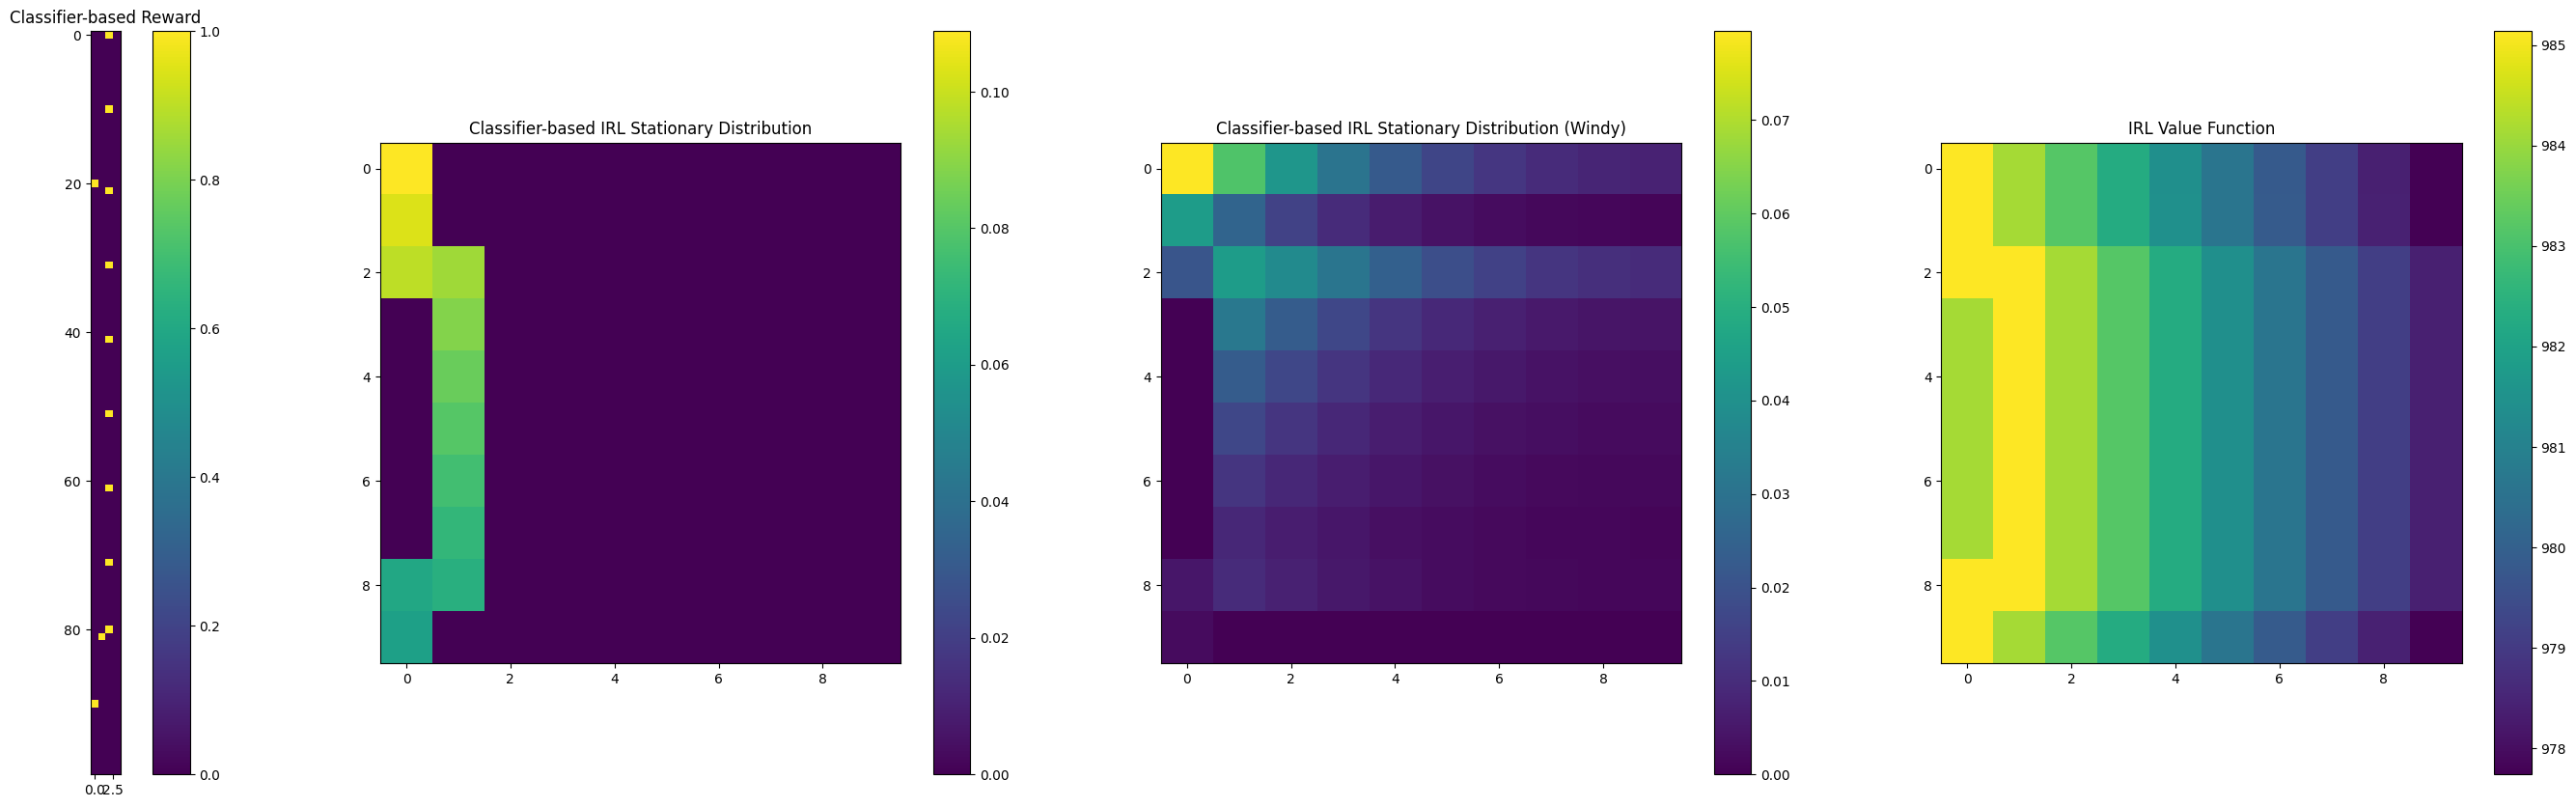

In [8]:
#@title Offline Classifier-style IRL (i.e. ORIL, ideal SQIL, ...)
classifier_reward = jnp.array(experience.sum(0) > 0.).astype(np.float32)
new_alpha = 0.01

classifier_pi, classifier_q, classifier_v = soft_policy_iteration(classifier_reward, transition_matrix, initial, prior_policy, alpha=new_alpha, gamma=discount, pi_init=bc_pi)
classifier_rho = stationary_distribution(initial, transition_matrix, classifier_pi, discount)
classifier_windy_rho = stationary_distribution(initial, windy_transition_matrix, classifier_pi, discount)

fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("Classifier-based Reward")
fig = ax_.imshow(classifier_reward)
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("Classifier-based IRL Stationary Distribution")
fig = ax_.imshow(classifier_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("Classifier-based IRL Stationary Distribution (Windy)")
fig = ax_.imshow(classifier_windy_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("IRL Value Function")
fig = ax_.imshow(classifier_v.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2549.71it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2527.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2638.38it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2636.43it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2506.01it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2565.31it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2596.18it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2489.47it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2509.59it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2550.16it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2519.65it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2635.61it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2723.54it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2603.49it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2582.51it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2622.19it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2608.85it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2614.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2540.26it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2561.80it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2521.43it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2678.30it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2689.24it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2560.48it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2646.50it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2647.27it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2698.26it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2646.98it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2739.57it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2725.91it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2741.84it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2729.12it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2599.30it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2590.21it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2586.52it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2690.99it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2749.21it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2751.93it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2589.81it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2652.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2668.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2708.48it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2704.69it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2711.65it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2726.37it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2747.41it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2736.14it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2553.50it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2561.42it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2435.70it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2557.33it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2536.84it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2498.25it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2708.71it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2639.77it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2647.33it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2596.26it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2653.72it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2704.24it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2701.40it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2652.74it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2577.98it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2585.60it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2615.33it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2657.47it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2657.09it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2609.94it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2603.17it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2543.88it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2634.98it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2709.01it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2745.36it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2732.32it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2727.97it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2680.48it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2624.75it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2585.80it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2612.26it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2534.84it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2671.58it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2648.02it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2686.80it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2481.87it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2580.32it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2605.85it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2603.43it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2631.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2650.26it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2622.39it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2402.87it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2520.42it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2544.35it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2521.43it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2628.26it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2569.83it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2578.65it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2666.54it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2618.02it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2516.41it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2579.97it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2572.69it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2699.12it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2653.93it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2554.65it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2578.52it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2618.41it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2574.46it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2563.18it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2683.93it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2559.31it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2473.96it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2609.73it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2602.81it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2628.04it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2539.36it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2643.46it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2616.83it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2652.46it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2613.03it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2642.78it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2565.14it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2582.30it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2690.05it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2676.08it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2684.99it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2699.49it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2734.73it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2722.94it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2724.35it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2729.03it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2350.00it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2438.02it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2570.04it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2542.08it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2578.11it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2607.44it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2682.33it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2648.39it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2490.24it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2674.15it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2617.60it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2743.19it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2650.19it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2518.77it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2585.60it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2530.88it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2666.30it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2714.02it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2646.15it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2583.72it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2550.75it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2591.35it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2616.50it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1723.60it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2479.61it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2426.95it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2376.15it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2384.20it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2345.93it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2527.94it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2584.12it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2532.88it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2405.42it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2605.19it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2669.51it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2617.86it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2503.27it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2497.75it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2566.61it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2527.80it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2523.13it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2605.58it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2757.47it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2728.14it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2610.56it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2557.94it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2612.95it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2731.11it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2484.72it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2325.94it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2532.99it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2490.92it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2537.68it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2600.59it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2641.38it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2576.20it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2599.44it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2528.78it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2524.74it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2529.78it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2525.24it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2612.67it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2673.15it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2512.94it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1939.15it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1973.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1798.50it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2477.51it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2349.08it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2443.55it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2466.99it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2527.36it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2556.94it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2590.87it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2541.16it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2602.25it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2540.00it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2298.46it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2579.98it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2515.28it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2518.51it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2562.46it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2523.47it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2628.11it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2428.24it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2307.81it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2527.22it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2511.18it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2463.72it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2587.93it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2561.00it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2596.34it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2595.24it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2536.19it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2534.20it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2616.08it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2540.89it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2519.22it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2600.30it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2723.47it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2531.13it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2548.35it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2580.97it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2560.55it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2698.46it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2458.82it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2421.95it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2512.24it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2667.03it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2569.98it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2678.59it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2731.41it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2738.31it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2581.57it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2544.35it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2734.62it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2760.97it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2725.84it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2686.80it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2633.19it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2464.15it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2425.81it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2305.06it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2343.40it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2073.40it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2222.28it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1914.46it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2231.89it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2323.96it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2259.84it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2171.61it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2367.76it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2462.93it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2549.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2510.15it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2008.31it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2354.66it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2495.14it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2506.04it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2489.05it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2549.06it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2538.91it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2582.40it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2596.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2481.01it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2619.77it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2496.39it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2535.41it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2490.40it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2417.91it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2547.25it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2541.11it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2528.76it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2632.98it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2538.28it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2516.59it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2604.32it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2460.22it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2500.00it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2485.53it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2491.60it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2459.30it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2433.03it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2546.86it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2662.14it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2605.17it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2350.99it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2578.11it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2577.86it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2555.98it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2564.35it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2518.25it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2717.61it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2534.41it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2554.42it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2530.04it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2573.73it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2405.47it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2502.57it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2570.62it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2506.89it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2614.51it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2619.85it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2677.31it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2374.33it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2369.94it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2299.17it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2482.32it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2562.80it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2673.52it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2537.44it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2573.07it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2544.08it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2335.80it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2598.70it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2541.69it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2570.10it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2729.80it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2709.31it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2739.51it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2742.95it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2737.26it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2696.73it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2754.73it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2633.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2464.19it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2458.52it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2365.57it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2506.26it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2578.84it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2717.47it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2739.50it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2607.02it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2350.46it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2356.32it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2329.42it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2605.74it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2672.31it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2565.68it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2599.15it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2739.50it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2631.98it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2476.65it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2514.78it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2366.41it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2175.85it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2392.12it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2578.92it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2676.17it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2515.46it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2510.66it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2261.63it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1681.63it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2234.25it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2555.40it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2652.02it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2552.97it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2651.97it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2401.58it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2362.34it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2381.06it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2534.41it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2635.31it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2687.81it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2526.34it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2694.04it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2444.33it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2335.79it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2263.00it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2559.00it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2609.05it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2630.14it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2525.56it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2619.87it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2704.59it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2732.61it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2568.58it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2420.31it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2320.23it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2331.66it/s]


Didn't converge!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2432.38it/s]


Didn't converge!


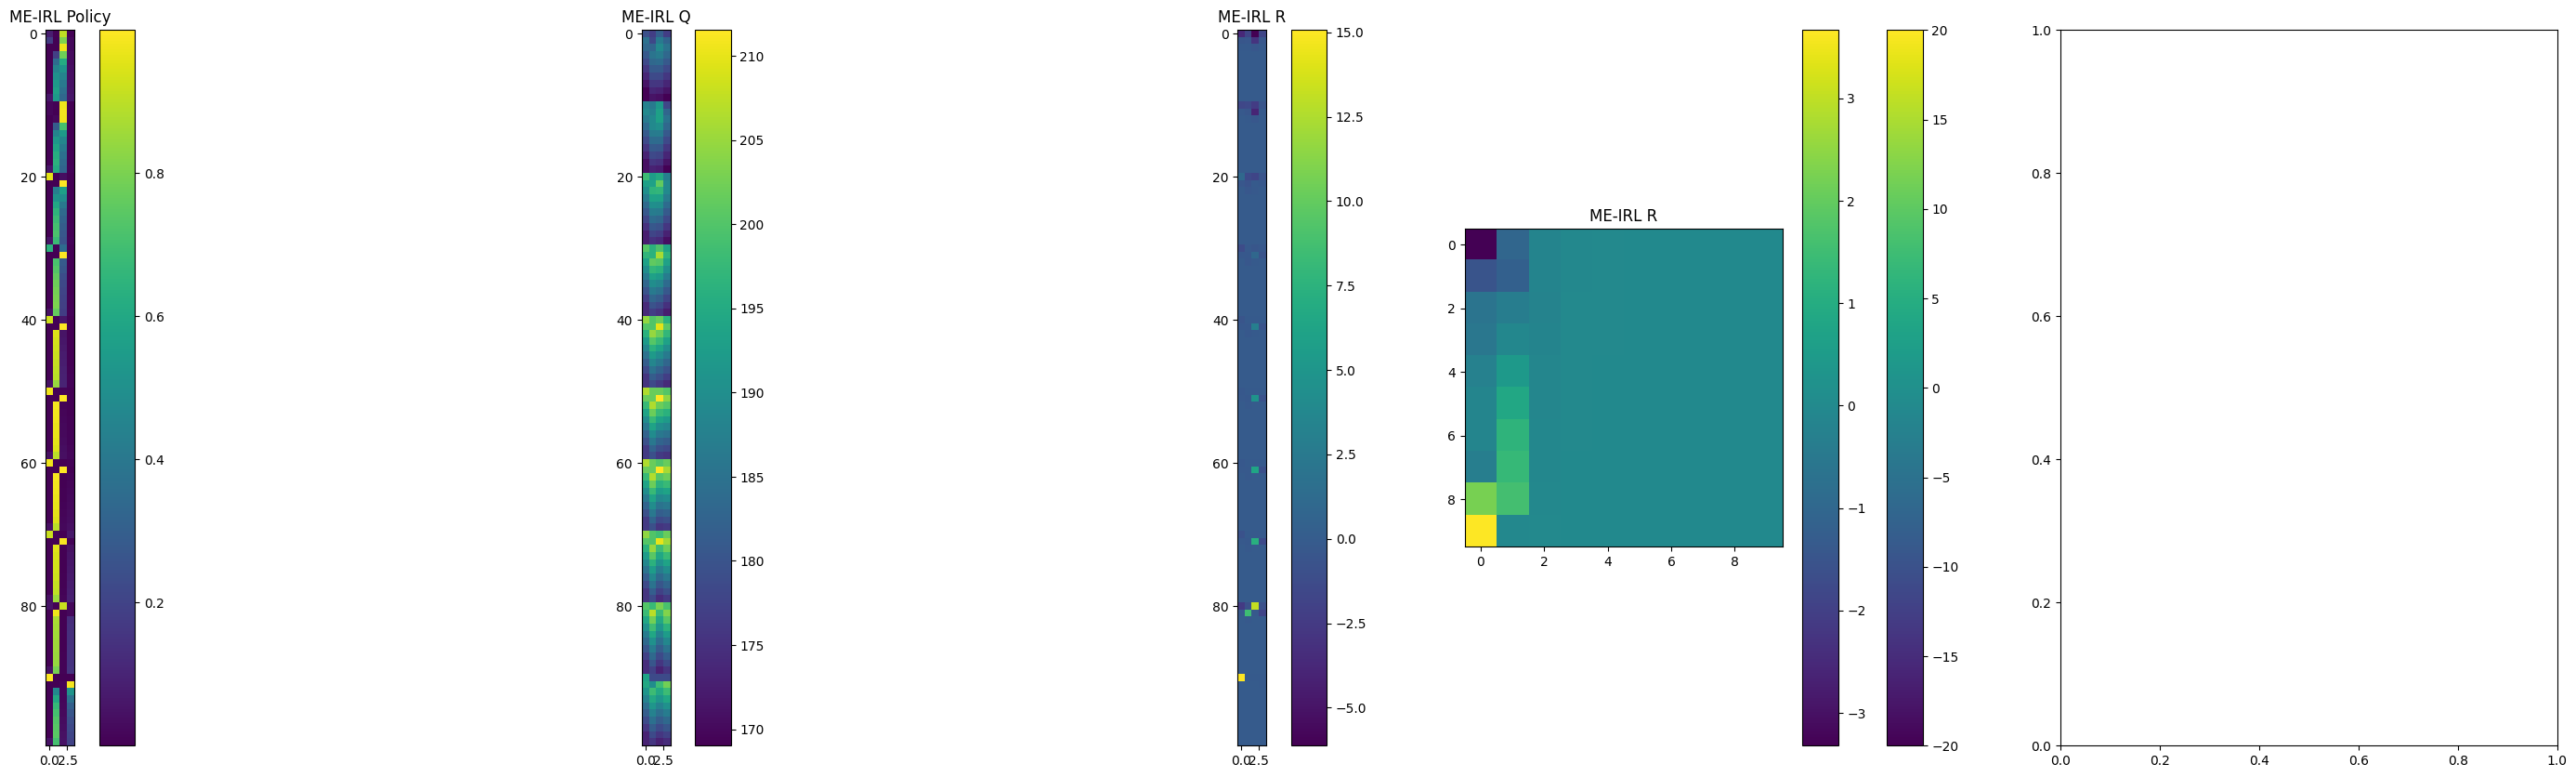

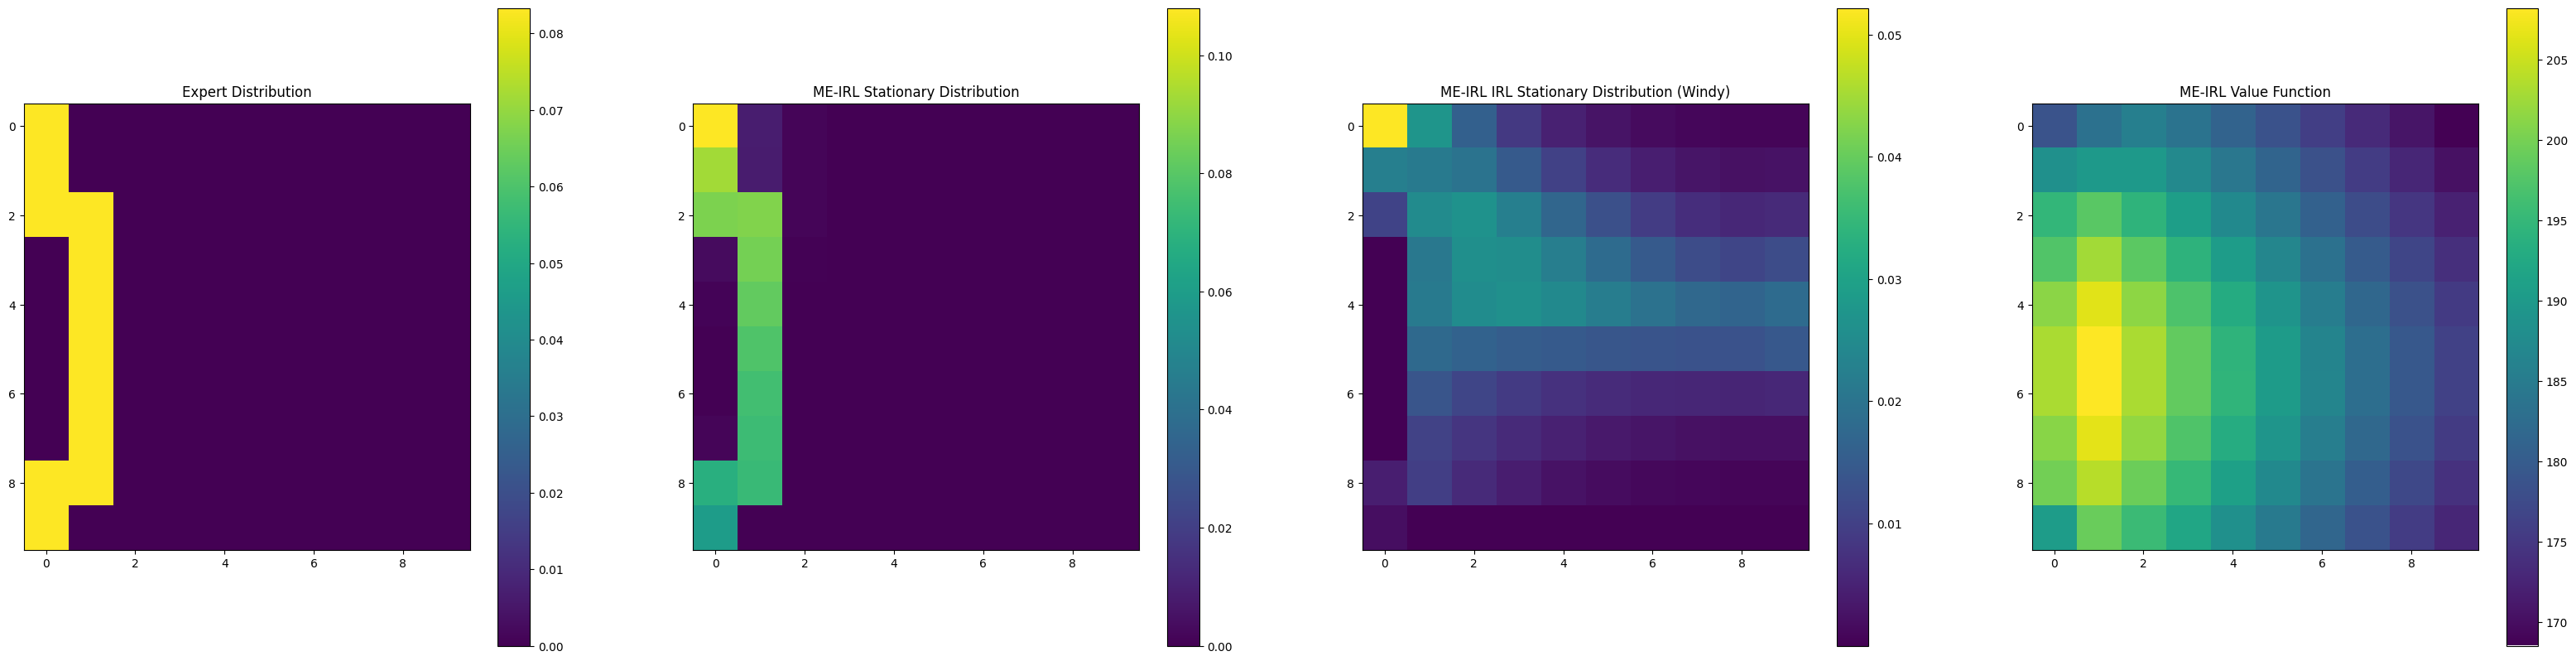

In [9]:
#@title Maximum Entropy IRL
def max_ent_irl(demonstratioon_distribution: jax.Array, transition: jax.Array,
                initial: jax.Array,  prior_policy: jax.Array, alpha: float, gamma: float,
                n_iters: int = 500, r_lr: float = 1.) -> Tuple[jax.Array, jax.Array, jax.Array, jax.Array]:
  """Maximum entropy inverse reinforcement learning (ME-IRL) with indicator features."""
  demonstration_distribution = demonstratioon_distribution / demonstratioon_distribution.sum()
  d_state, d_action, _ = transition.shape
  meirl_reward = jnp.zeros((d_state, d_action))
  errors = []
  for _ in range(n_iters):
    # run SPI on current reward and get stationary distribution
    pi_irl, q, v = soft_policy_iteration(meirl_reward, transition, initial, prior_policy, alpha=alpha, gamma=gamma, n_iters=100)
    irl_rho = stationary_distribution(initial, transition, pi_irl, discount, n_iters=100)
    irl_distribution = jnp.diag(irl_rho) @ pi_irl
    # compute error on feature matching constraint
    error = (demonstration_distribution - irl_distribution)
    violation = (error ** 2).mean()
    errors += [violation]
    if len(errors) > 1 and (abs(errors[-1] - errors[-2]) / abs(errors[-2]) < 1e-5):  # check for convergence
      break
    # gradient update on Lagrange multiplier
    meirl_reward += r_lr * error
  return pi_irl, q, v, meirl_reward

alpha_meirl = 1.
meirl_pi, meirl_q, meirl_v, meirl_reward = max_ent_irl(expert_distribution, transition_matrix, initial, prior_policy, alpha_meirl, gamma)

meirl_rho = stationary_distribution(initial, transition_matrix, meirl_pi, discount)
meirl_windy_rho = stationary_distribution(initial, windy_transition_matrix, meirl_pi, discount)

fig, ax = plt.subplots(1, 5, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("ME-IRL Policy")
fig = ax_.imshow(meirl_pi)
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("ME-IRL Q")
fig = ax_.imshow(meirl_q)
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("ME-IRL R")
fig = ax_.imshow(meirl_reward)
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("True R")
fig = ax_.imshow(reward)
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("ME-IRL R")
fig = ax_.imshow(meirl_reward.mean(1).reshape((width, width)))
plt.colorbar(fig, ax=ax_)

fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("Expert Distribution")
fig = ax_.imshow(expert_distribution.sum(1).reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("ME-IRL Stationary Distribution")
fig = ax_.imshow(meirl_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("ME-IRL IRL Stationary Distribution (Windy)")
fig = ax_.imshow(meirl_windy_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("ME-IRL Value Function")
fig = ax_.imshow(meirl_v.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2712.60it/s]


-14.9731558323715


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2731.06it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2546.22it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2551.22it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2290.63it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2551.30it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2643.90it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2650.48it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2714.43it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2741.97it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2725.31it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2610.69it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2729.64it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2692.52it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2753.54it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2685.28it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2564.82it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2709.13it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2748.78it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2745.45it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2678.15it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2722.87it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2700.31it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2750.35it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2586.71it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2718.21it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2692.21it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2739.50it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2675.45it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2517.88it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2328.07it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2546.86it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2615.39it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2702.27it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2729.42it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2697.02it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2597.99it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2704.76it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2643.90it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2693.66it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2635.13it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2681.69it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2727.31it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2733.07it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2675.01it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2717.91it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2724.26it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2487.70it/s]

Didn't converge!


-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2545.43it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2467.25it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2653.98it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2695.64it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2193.74it/s]

Didn't converge!


-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2502.63it/s]

Didn't converge!


-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2387.21it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2449.24it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2444.70it/s]

Didn't converge!
-13.862942695618129



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2497.52it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2506.53it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2462.98it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2609.79it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2322.57it/s]

Didn't converge!


-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2431.16it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2561.67it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2547.92it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2276.65it/s]

Didn't converge!


-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2468.22it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2540.60it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2508.19it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2549.79it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2429.73it/s]

Didn't converge!


-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2520.54it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2446.13it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2680.89it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2724.42it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2621.39it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2448.46it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2593.29it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2641.80it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2327.91it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2225.54it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2477.35it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2558.39it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2560.61it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2517.26it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2512.24it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2516.67it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2464.58it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2469.31it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2431.09it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2576.20it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2470.73it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2523.19it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2413.49it/s]

Didn't converge!


-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2451.52it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2425.13it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2464.51it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2522.69it/s]


Didn't converge!
-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2392.79it/s]

Didn't converge!


-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2434.22it/s]

Didn't converge!


-13.862942695618129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2555.77it/s]


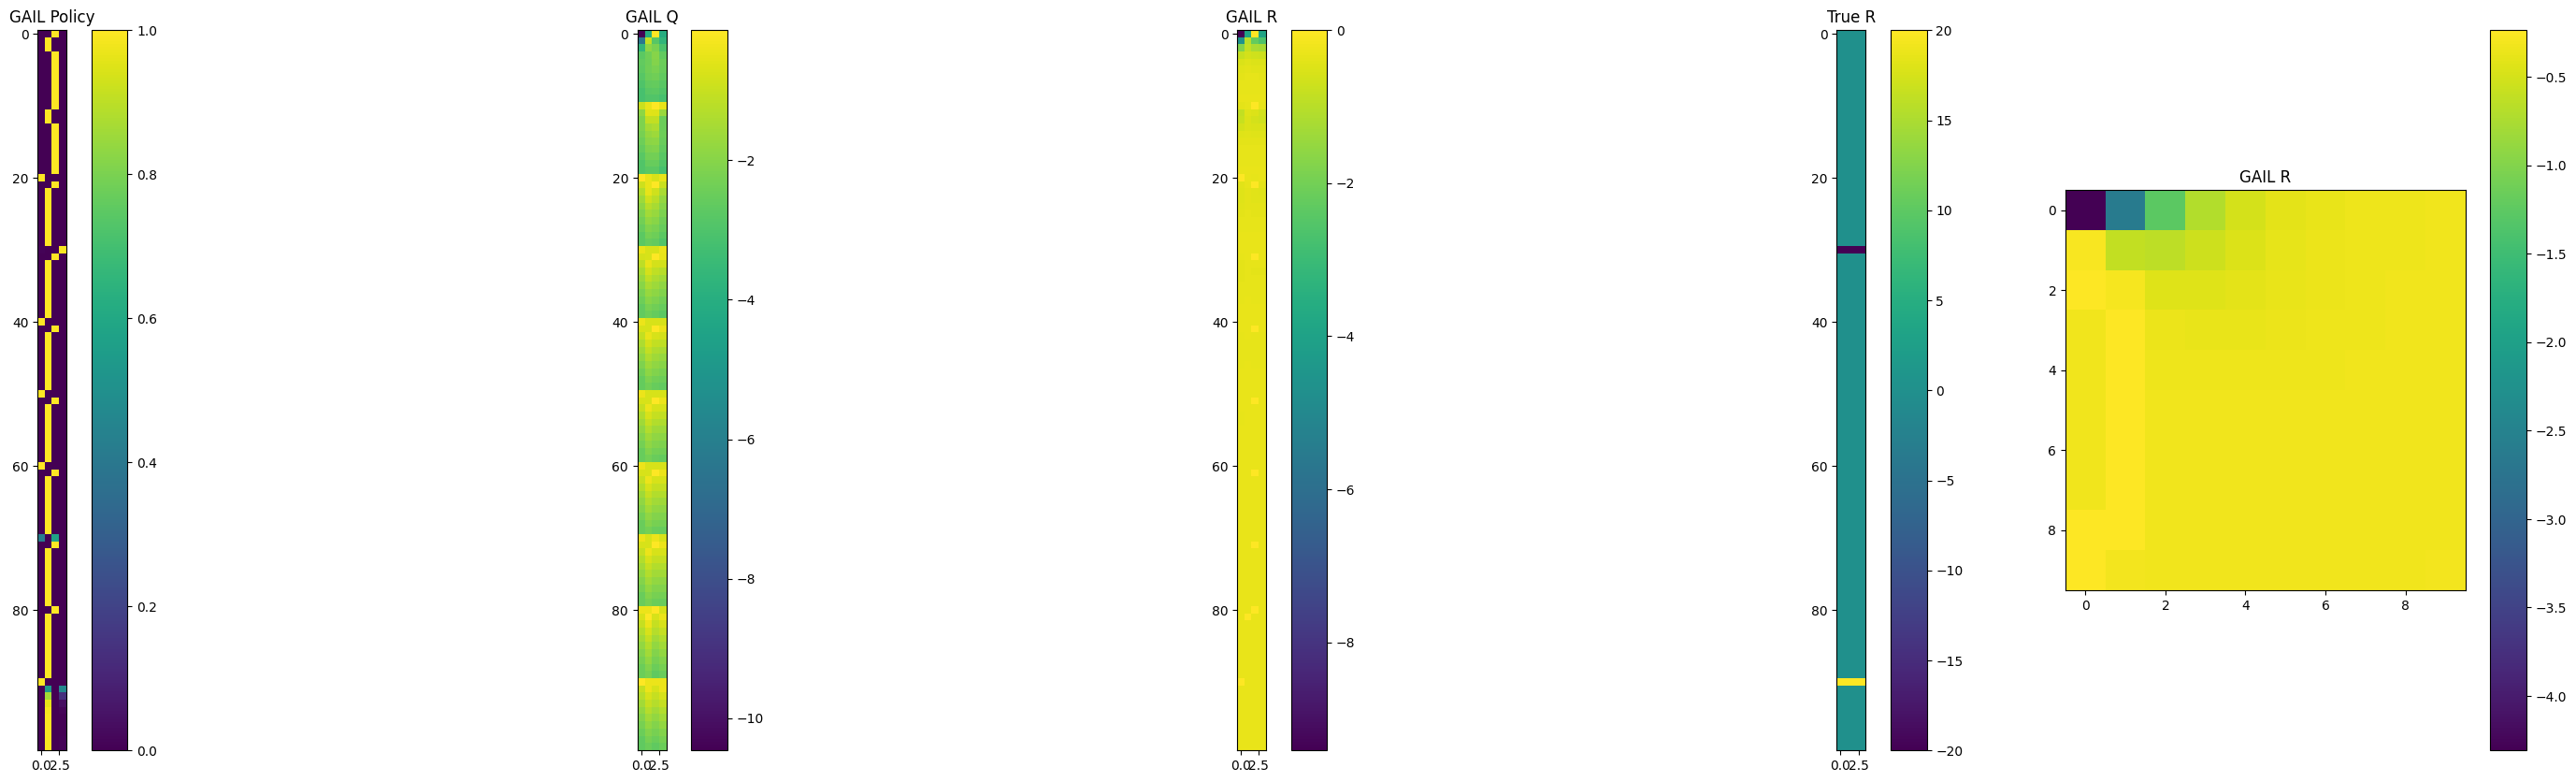

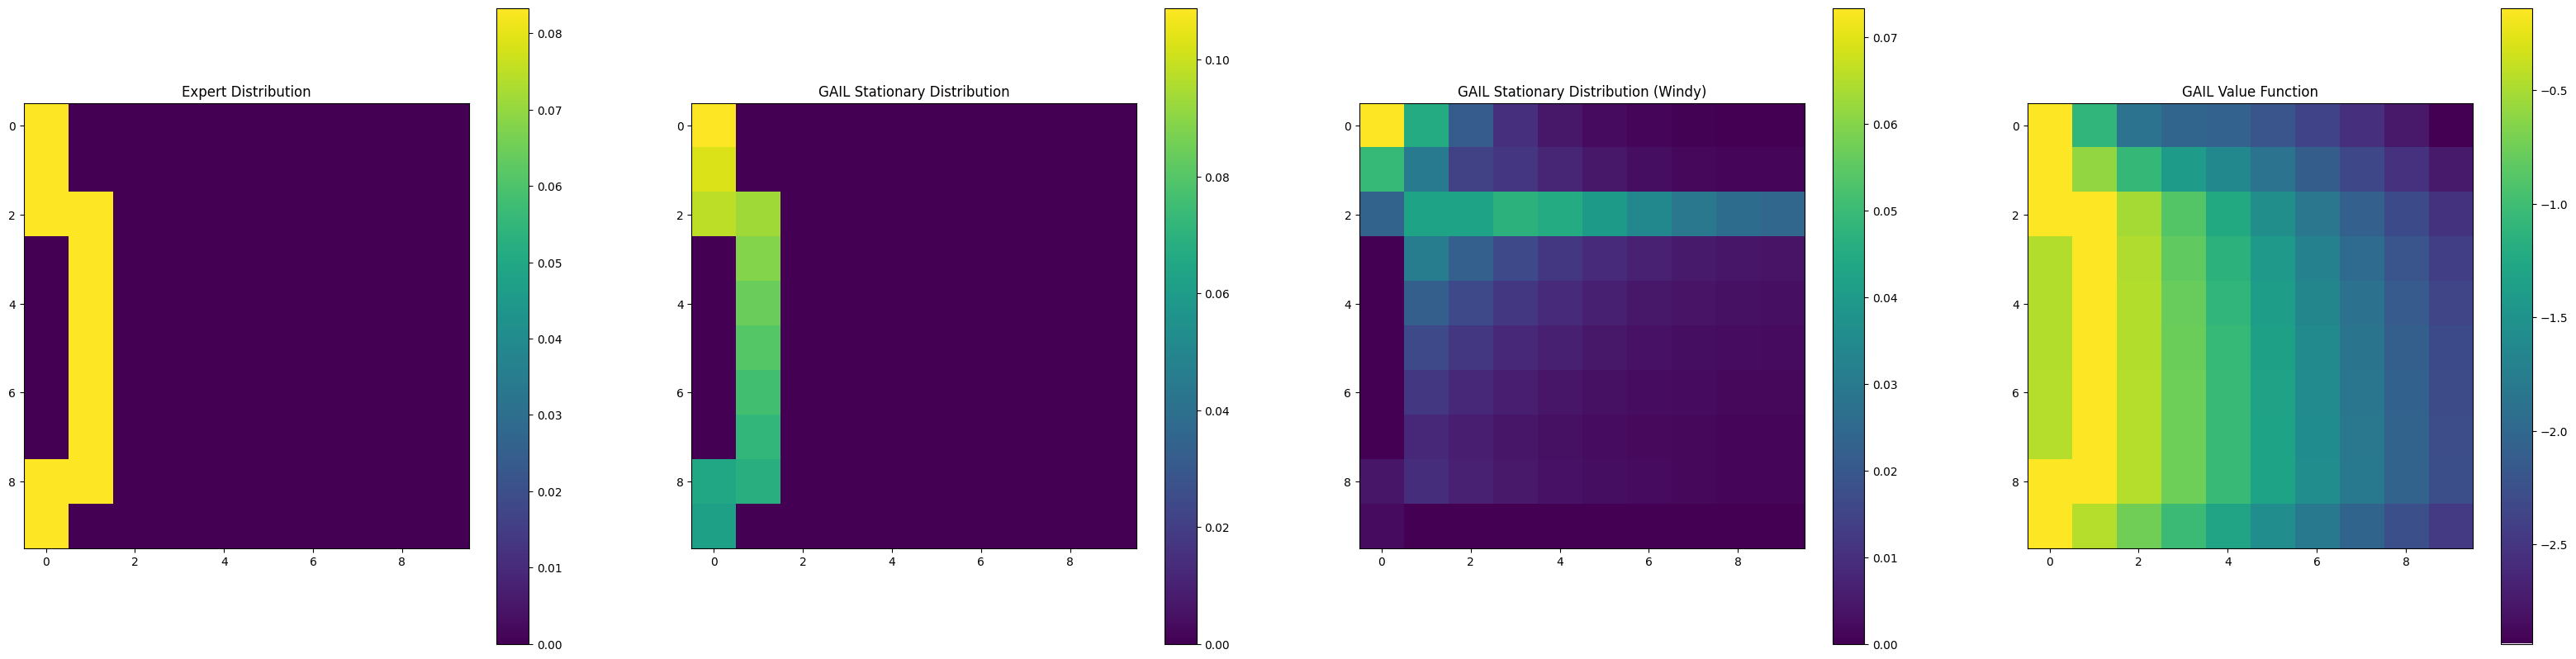

In [10]:
# @title Generative adversarial imitation learning (GAIL)

classifier_reward = 1. - jnp.array(experience.sum(0) > 0.).astype(np.float32)  # naive guess at classifier based on occupancy

@jax.jit
def discrimator_loss(weights: jax.Array, expert_distribution: jax.Array, policy_distribution: jax.Array) -> jax.Array:
    """Logistic loss for the classifier."""
    classification = jax.nn.sigmoid(weights)
    loss = jnp.log(EPS + 1. - classification) * expert_distribution
    loss += jnp.log(EPS + classification) * policy_distribution
    return loss.sum()

discrimator_grad = jax.value_and_grad(discrimator_loss)

def gail(expert_distribution: jax.Array, transition: jax.Array, initial: jax.Array,  prior_policy: jax.Array,
         alpha: float, gamma: float, n_iters: int = 100, r_lr: float = 1., classifier_iters: int = 200):
  """Implement generative adversarial imitation learning (GAIL) where the dynamics are known."""
  expert_distribution = expert_distribution / expert_distribution.sum()
  d_state, d_action, _ = transition.shape
  discriminator_weights = classifier_reward
  for _ in range(n_iters):
    # construct reward from classifier
    gail_reward = jnp.log(EPS + jax.nn.sigmoid(discriminator_weights))
    # run SPI on reward
    pi_irl, q, v = soft_policy_iteration(gail_reward, transition_matrix, initial, prior_policy, alpha=alpha, gamma=gamma, n_iters=100)
    pi_rho = stationary_distribution(initial, transition_matrix, pi_irl, discount, n_iters=100)
    irl_distribution = jnp.diag(pi_rho) @ pi_irl
    # train classifier between stationary distributions
    for _ in range(classifier_iters):
      r_loss, r_grad = discrimator_grad(discriminator_weights, expert_distribution, irl_distribution)
      discriminator_weights -= r_lr * r_grad
    print(r_loss)
  pi, q, v = soft_policy_iteration(gail_reward, transition_matrix, initial, prior_policy, alpha=alpha, gamma=gamma, n_iters=100)
  return pi, q, v, jnp.log(EPS + jax.nn.sigmoid(discriminator_weights))

gail_alpha = 1e-3
gail_pi, gail_q, gail_v, gail_reward = gail(expert_distribution, transition_matrix, initial, prior_policy, gail_alpha, gamma)

gail_rho = stationary_distribution(initial, transition_matrix, gail_pi, discount)
gail_windy_rho = stationary_distribution(initial, windy_transition_matrix, gail_pi, discount)

fig, ax = plt.subplots(1, 5, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("GAIL Policy")
fig = ax_.imshow(gail_pi)
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("GAIL Q")
fig = ax_.imshow(gail_q)
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("GAIL R")
fig = ax_.imshow(gail_reward)
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("True R")
fig = ax_.imshow(reward)
plt.colorbar(fig, ax=ax_)

ax_ = ax[4]
ax_.set_title("GAIL R")
fig = ax_.imshow(gail_reward.mean(1).reshape((width, width)))
plt.colorbar(fig, ax=ax_)

fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("Expert Distribution")
fig = ax_.imshow(expert_distribution.sum(1).reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("GAIL Stationary Distribution")
fig = ax_.imshow(gail_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("GAIL Stationary Distribution (Windy)")
fig = ax_.imshow(gail_windy_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("GAIL Value Function")
fig = ax_.imshow(gail_v.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 932.47it/s]


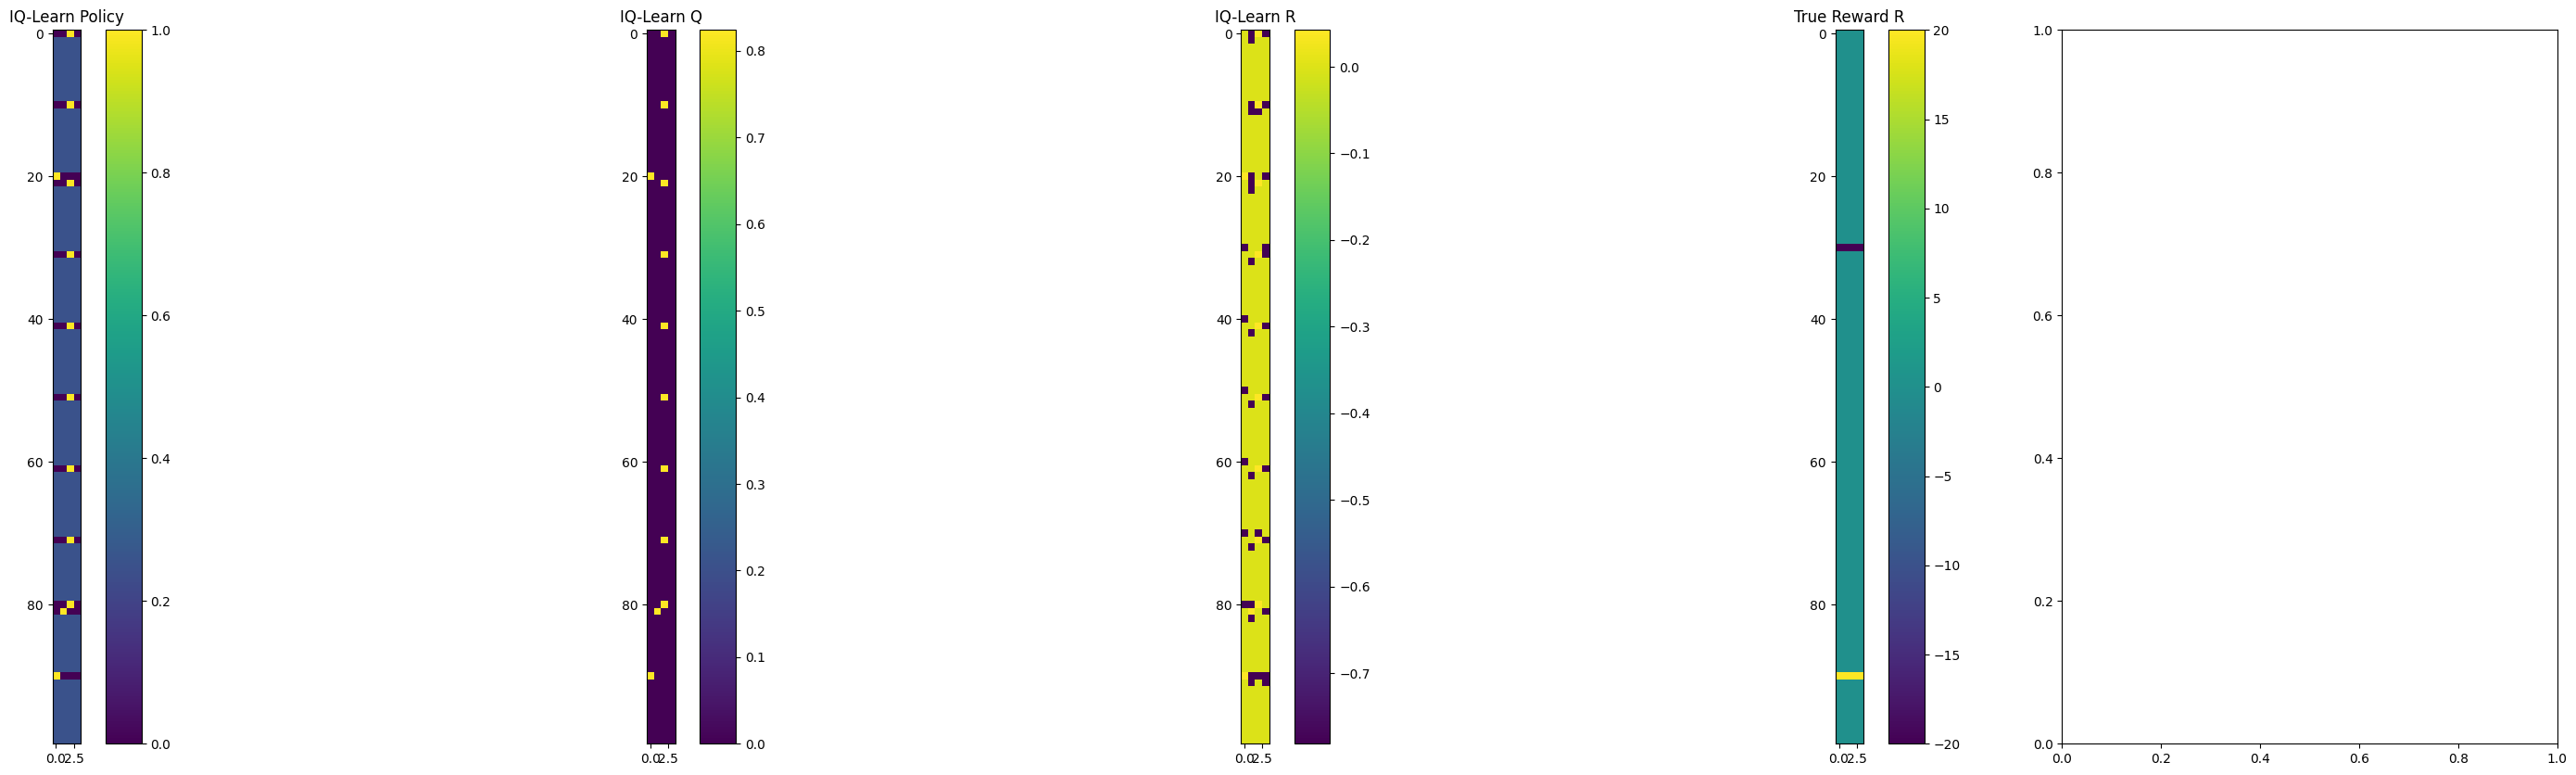

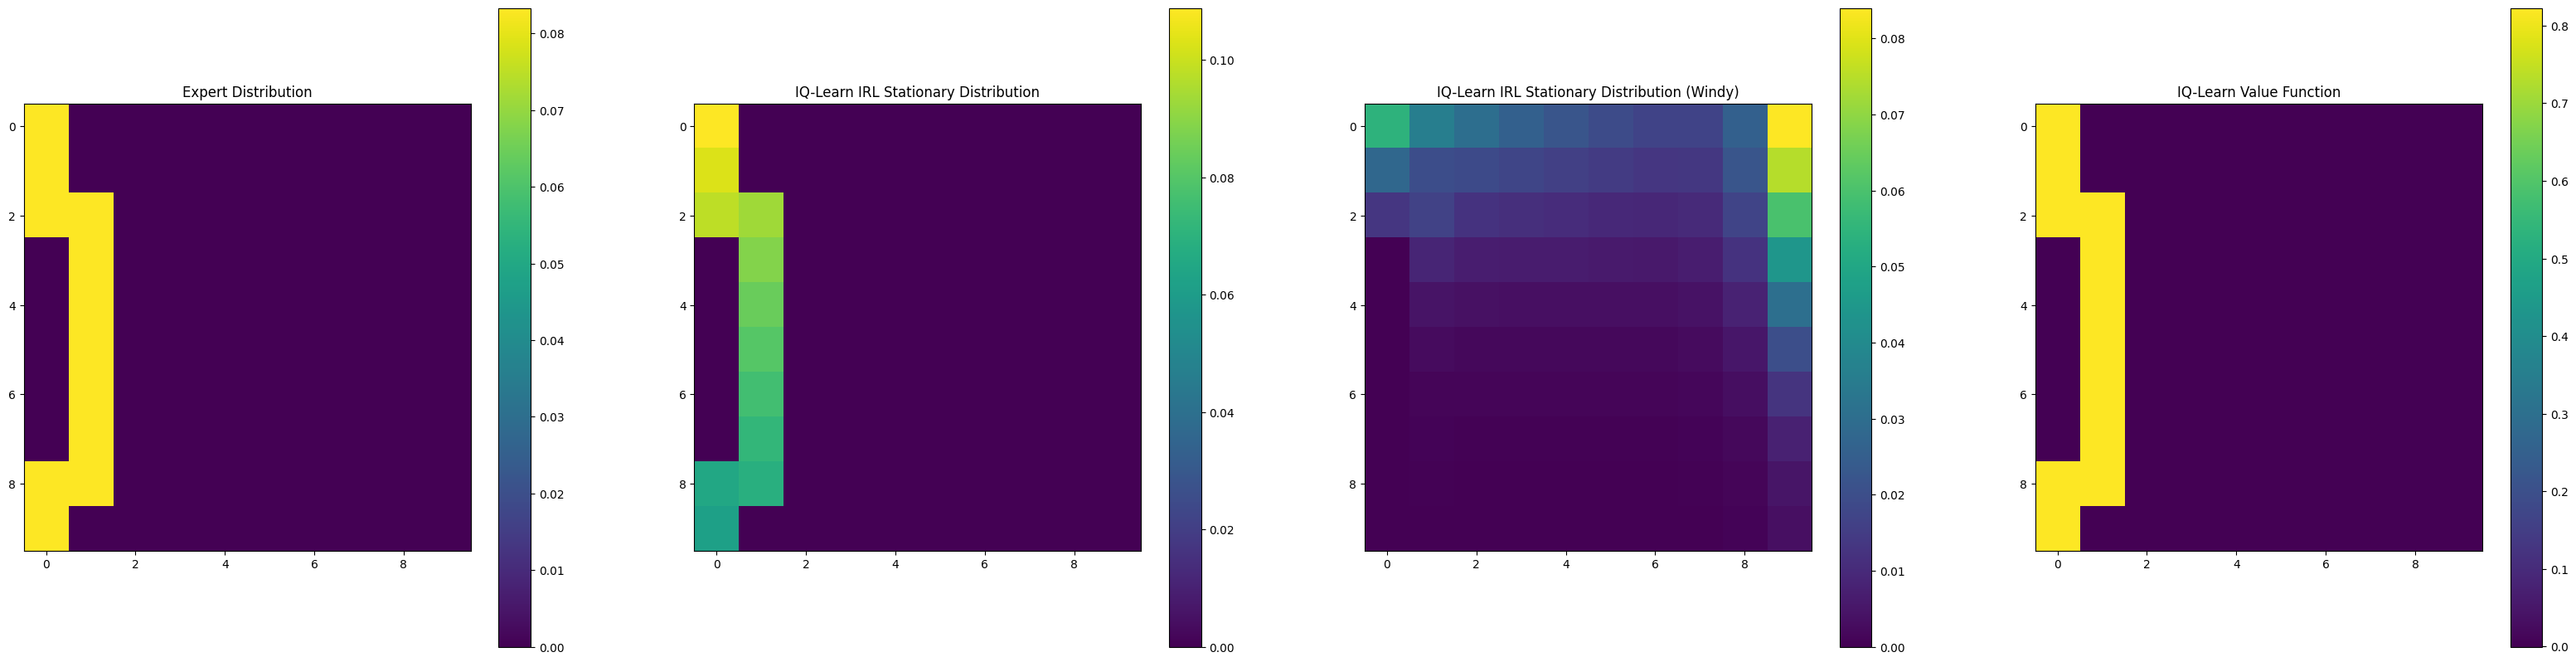

In [11]:
# @title Inverse Soft Q Learning (IQLearn)
convex_reg = lambda x: x - 0.25 * x ** 2

@jax.jit
def iq_learn_loss(q: jax.Array, expert_distribution: jax.Array, pi: jax.Array, transition: jax.Array,
                  initial: jax.Array, prior_policy: jax.Array, discount: float, alpha: float) -> jax.Array:
    pi_kl = jnp.sum(pi * (jnp.log(prior_policy) - jnp.log(EPS + pi)), axis=1)
    v = jax.lax.stop_gradient(jnp.sum(q * pi, axis=1) + alpha * pi_kl)
    imp_reward = q - gamma * jnp.sum(transition * jnp.tile(v, (d_state, d_action, 1)), 2)
    objective = (expert_distribution * convex_reg(imp_reward)).sum() - (1-gamma) * jnp.sum(initial * v)
    return -objective

iq_learn_grad = jax.grad(iq_learn_loss)

def inverse_q_learning(expert_distribution: jax.Array, transition: jax.Array, initial: jax.Array, prior_policy: jax.Array,
                       alpha: float, gamma: float, n_iters: int = 1000, q_lr: float = 1e-2
                      ) -> Tuple[jax.Array, jax.Array, jax.Array, jax.Array]:
  """Inverse Q learning (IQLearn)."""
  d_state, d_action, _ = transition.shape
  q_ = jnp.zeros((d_state, d_action))
  pi_ = jnp.ones(((d_state, d_action))) / d_action
  for i in tqdm(range(n_iters)):
    # optimize the Q values w.r.t. the IQLearn loss
    pi_kl = jnp.sum(pi_ * (jnp.log(EPS + pi_) - jnp.log(prior_policy)), axis=1)
    v_ = jnp.sum(q_ * pi_, axis=1) - alpha * pi_kl
    q_grad = iq_learn_grad(q_, expert_distribution, pi_, transition_matrix, initial, prior_policy, discount, alpha)
    q_ = q_ - q_lr * q_grad
    # update the policy given Q
    pi_ = softmax(q_, alpha, prior_policy)

  pi_kl = jnp.sum(pi_ * (jnp.log(EPS + pi_) - jnp.log(prior_policy)), axis=1)
  v_ = jnp.sum(q_ * pi_, axis=1) - alpha * pi_kl
  imp_reward = q_ - gamma * jnp.sum(transition * jnp.tile(v_, (d_state, d_action, 1)), 2)
  return pi_, q_, v_, imp_reward

iq_alpha = 1e-3
iq_pi, iq_q, iq_v, iq_r = inverse_q_learning(expert_distribution, transition_matrix, initial, prior_policy, iq_alpha, gamma)

iq_rho = stationary_distribution(initial, transition_matrix, iq_pi, discount)
iq_windy_rho = stationary_distribution(initial, windy_transition_matrix, iq_pi, discount)

iq_v = iq_v
iq_windy_rho = iq_windy_rho

fig, ax = plt.subplots(1, 5, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("IQ-Learn Policy")
fig = ax_.imshow(iq_pi)
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("IQ-Learn Q")
fig = ax_.imshow(iq_q)
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("IQ-Learn R")
fig = ax_.imshow(iq_r)
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("True Reward R")
fig = ax_.imshow(reward)
plt.colorbar(fig, ax=ax_)


fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("Expert Distribution")
fig = ax_.imshow(expert_distribution.sum(1).reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("IQ-Learn IRL Stationary Distribution")
fig = ax_.imshow(iq_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("IQ-Learn IRL Stationary Distribution (Windy)")
fig = ax_.imshow(iq_windy_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("IQ-Learn Value Function")
fig = ax_.imshow(iq_v.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

  0%|                                                                                                                                                           | 0/25 [00:00<?, ?it/s]

Didn't converge!



  4%|█████▉                                                                                                                                             | 1/25 [00:00<00:10,  2.31it/s]

Didn't converge!



  8%|███████████▊                                                                                                                                       | 2/25 [00:00<00:08,  2.68it/s]

Didn't converge!



 12%|█████████████████▋                                                                                                                                 | 3/25 [00:01<00:07,  2.80it/s]

Didn't converge!



 16%|███████████████████████▌                                                                                                                           | 4/25 [00:01<00:07,  2.77it/s]

Didn't converge!



 20%|█████████████████████████████▍                                                                                                                     | 5/25 [00:01<00:06,  2.87it/s]

Didn't converge!



 24%|███████████████████████████████████▎                                                                                                               | 6/25 [00:02<00:06,  2.93it/s]

Didn't converge!



 28%|█████████████████████████████████████████▏                                                                                                         | 7/25 [00:02<00:06,  2.95it/s]

Didn't converge!



 32%|███████████████████████████████████████████████                                                                                                    | 8/25 [00:02<00:05,  2.98it/s]

Didn't converge!



 36%|████████████████████████████████████████████████████▉                                                                                              | 9/25 [00:03<00:05,  2.98it/s]

Didn't converge!



 40%|██████████████████████████████████████████████████████████▍                                                                                       | 10/25 [00:03<00:04,  3.04it/s]

Didn't converge!



 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 11/25 [00:03<00:04,  2.97it/s]

Didn't converge!



 48%|██████████████████████████████████████████████████████████████████████                                                                            | 12/25 [00:04<00:04,  3.08it/s]

Didn't converge!



 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 13/25 [00:04<00:03,  3.02it/s]

Didn't converge!



 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 14/25 [00:04<00:03,  2.97it/s]

Didn't converge!



 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 15/25 [00:05<00:03,  3.03it/s]

Didn't converge!



 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 16/25 [00:05<00:02,  3.13it/s]

Didn't converge!



 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 17/25 [00:05<00:02,  3.17it/s]

Didn't converge!



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 18/25 [00:06<00:02,  3.18it/s]

Didn't converge!



 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 19/25 [00:06<00:01,  3.13it/s]

Didn't converge!



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 20/25 [00:06<00:01,  2.98it/s]

Didn't converge!



 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 21/25 [00:07<00:01,  2.95it/s]

Didn't converge!



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 22/25 [00:07<00:01,  2.99it/s]

Didn't converge!



 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 23/25 [00:07<00:00,  3.04it/s]

Didn't converge!



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 24/25 [00:08<00:00,  3.03it/s]

Didn't converge!



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.99it/s]


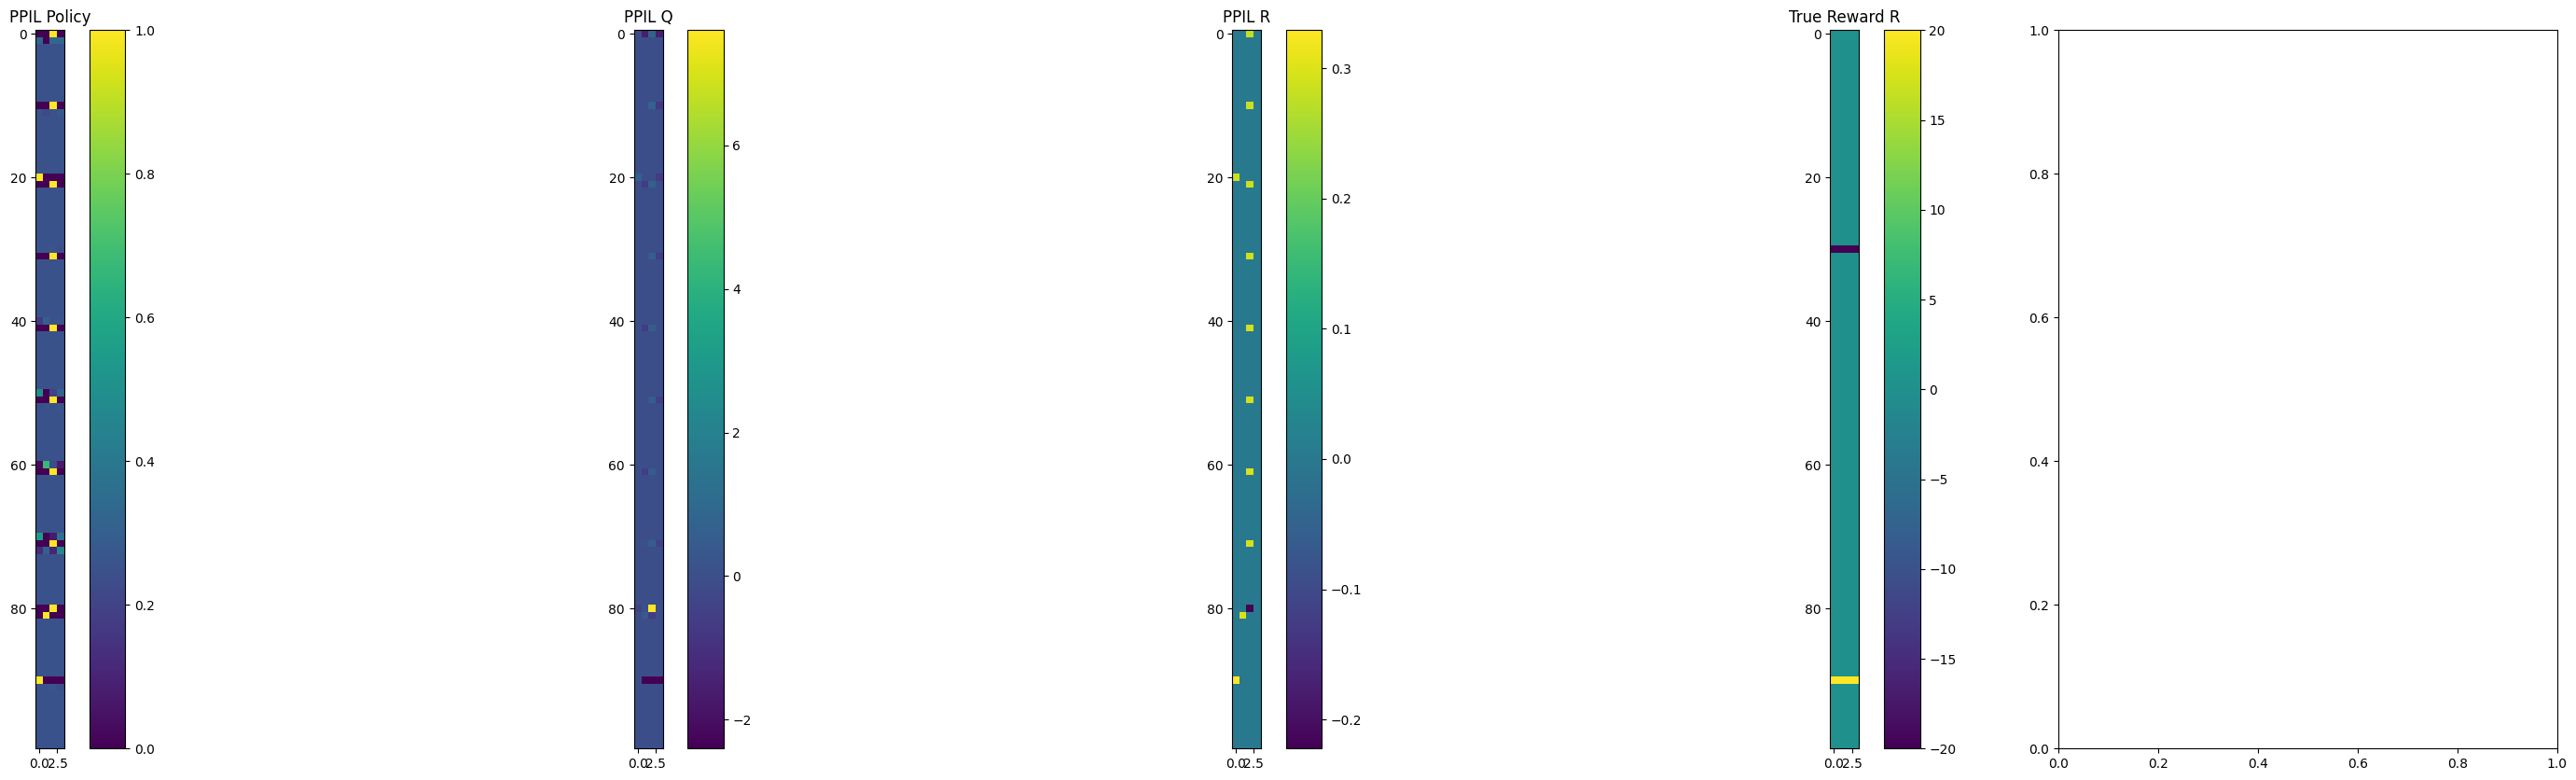

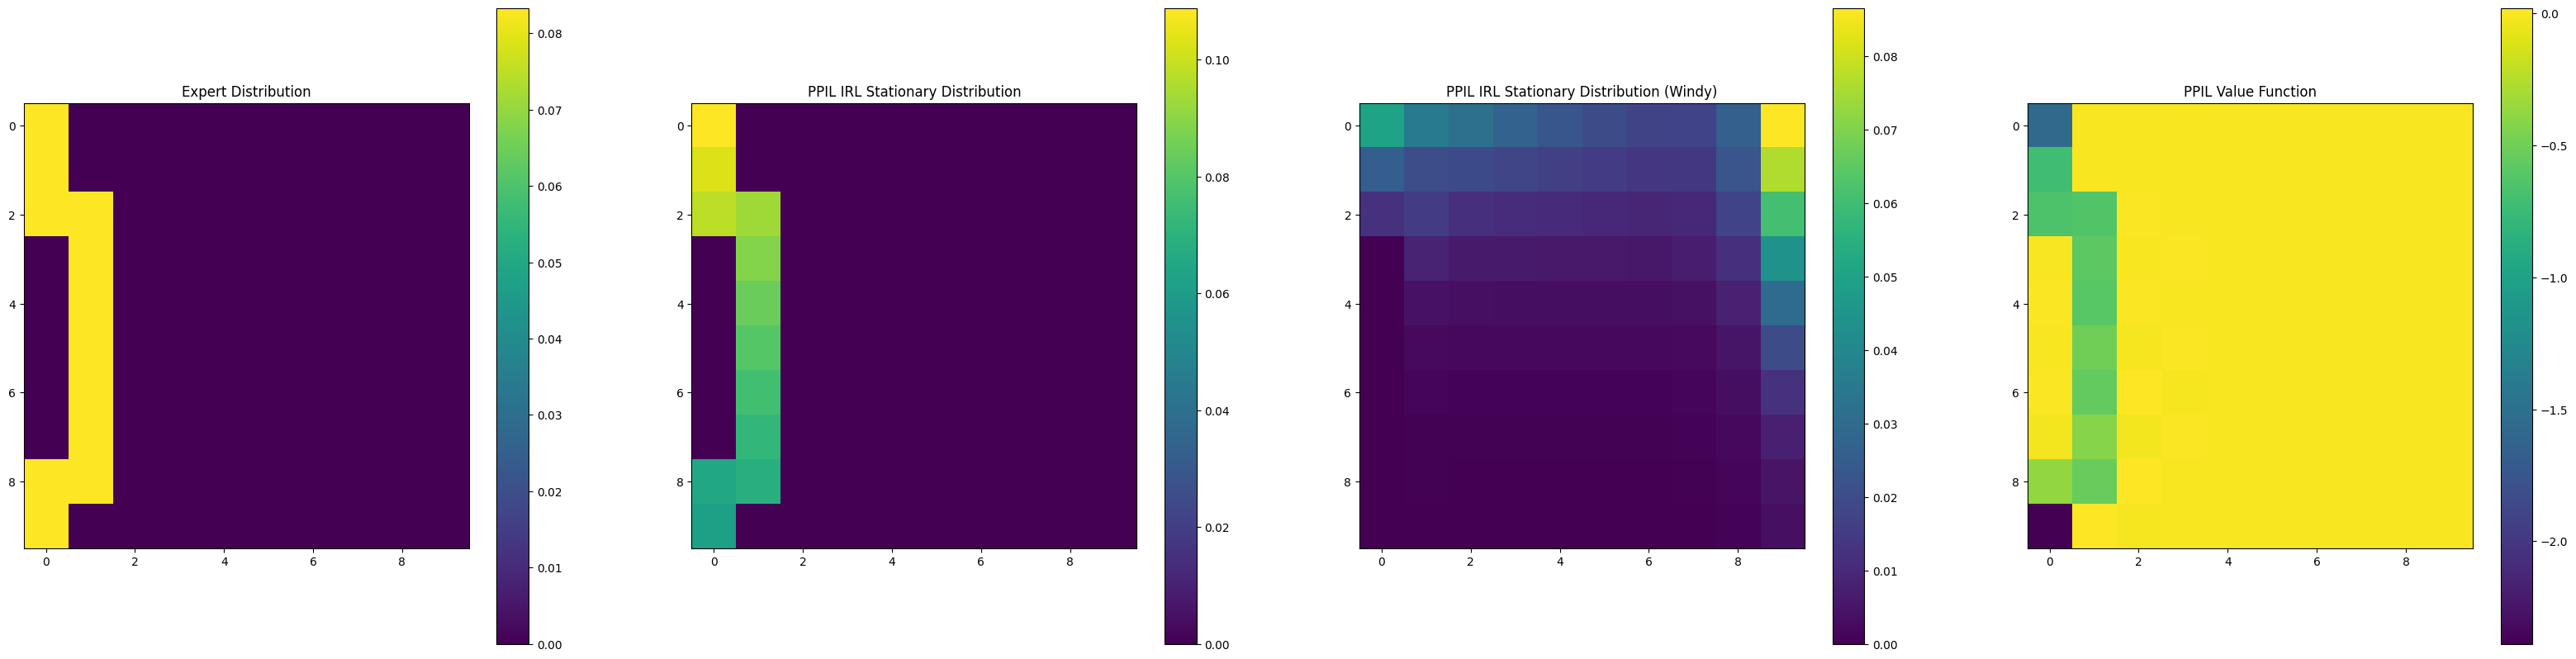

In [12]:
# @title Proximal Point Imitation Learning (PPIL)

@jax.jit
def dual(q: jax.Array, r: jax.Array, expert_distribution: jax.Array, policy_distribution: jax.Array, pi: jax.Array,
         transition: jax.Array, initial: jax.Array, prior_policy: jax.Array, discount: float, alpha: float
        ) -> jax.Array:
    """Dual objective defined in Equation X of Viano et al."""
    expert_reward = (r * expert_distribution).sum()
    v = -alpha * jax.scipy.special.logsumexp(-q / alpha + jnp.log(EPS + prior_policy), axis=1)
    q_target = r + discount * jnp.sum(transition * jnp.tile(v, (d_state, d_action, 1)), 2)
    be = q_target - q
    w = jax.lax.stop_gradient(jax.nn.softmax(1e-2 * be))
    sbe = (policy_distribution * w * be).sum()
    dual = expert_reward - sbe - (1 - discount) * jnp.sum(initial * v)
    return -dual

dual_grad = jax.value_and_grad(dual, argnums=(0, 1))

def proximal_point_imitiation_learning(expert_distribution: jax.Array, transition: jax.Array, initial: jax.Array, prior_policy: jax.Array,
                                       alpha: float, gamma: float, n_iters: int = 250, lr: float = 1e-2
                                      ) -> Tuple[jax.Array, jax.Array, jax.Array, jax.Array]:
  d_state, d_action, _ = transition.shape
  q_ = jnp.zeros((d_state, d_action))
  r_ = jnp.zeros((d_state, d_action))
  pi_ = prior_policy
  for j in tqdm(range(25)):
    policy_distribution = stationary_distribution(initial, transition_matrix, pi_, discount, n_iters=10)
    policy_distribution = jnp.diag(policy_distribution) @ pi_
    for i in tqdm(range(n_iters)):
      d, grads = dual_grad(q_, r_, expert_distribution, policy_distribution, pi_, transition_matrix, initial, pi_, discount, alpha)
      q_grad, r_grad = grads
      q_ = q_ - lr * q_grad
      r_ = r_ - lr * r_grad
      r_ = r_ / (r_ ** 2).sum()
    pi_ = softmax(q_, alpha, prior_policy)

  v_ = -alpha * jax.scipy.special.logsumexp(-q_ / alpha + jnp.log(EPS + pi_), axis=1)
  return pi_, q_, v_, r_

alpha_ppil = 1e-3
ppil_pi, ppil_q, ppil_v, ppil_r = proximal_point_imitiation_learning(
    expert_distribution, transition_matrix, initial, prior_policy, alpha_ppil, gamma)

ppil_rho = stationary_distribution(initial, transition_matrix, ppil_pi, discount)
ppil_windy_rho = stationary_distribution(initial, windy_transition_matrix, ppil_pi, discount)

fig, ax = plt.subplots(1, 5, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("PPIL Policy")
fig = ax_.imshow(ppil_pi)
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("PPIL Q")
fig = ax_.imshow(ppil_q)
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("PPIL R")
fig = ax_.imshow(ppil_r)
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("True Reward R")
fig = ax_.imshow(reward)
plt.colorbar(fig, ax=ax_)


fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("Expert Distribution")
fig = ax_.imshow(expert_distribution.sum(1).reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[1]
ax_.set_title("PPIL IRL Stationary Distribution")
fig = ax_.imshow(ppil_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[2]
ax_.set_title("PPIL IRL Stationary Distribution (Windy)")
fig = ax_.imshow(ppil_windy_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

ax_ = ax[3]
ax_.set_title("PPIL Value Function")
fig = ax_.imshow(ppil_v.reshape((width, width)))
plt.colorbar(fig, ax=ax_)

,Deterministic,Windy
Greedy Soft Expert,1.237,0.052
Soft Expert,1.237,0.052
BC,1.237,0.002
CLASSIFIER,1.237,0.044
ME-IRL,1.131,0.036
GAIL,1.237,0.043
IQLEARN,1.237,0.002
PPIL,1.237,0.002
CSIL,1.237,0.044


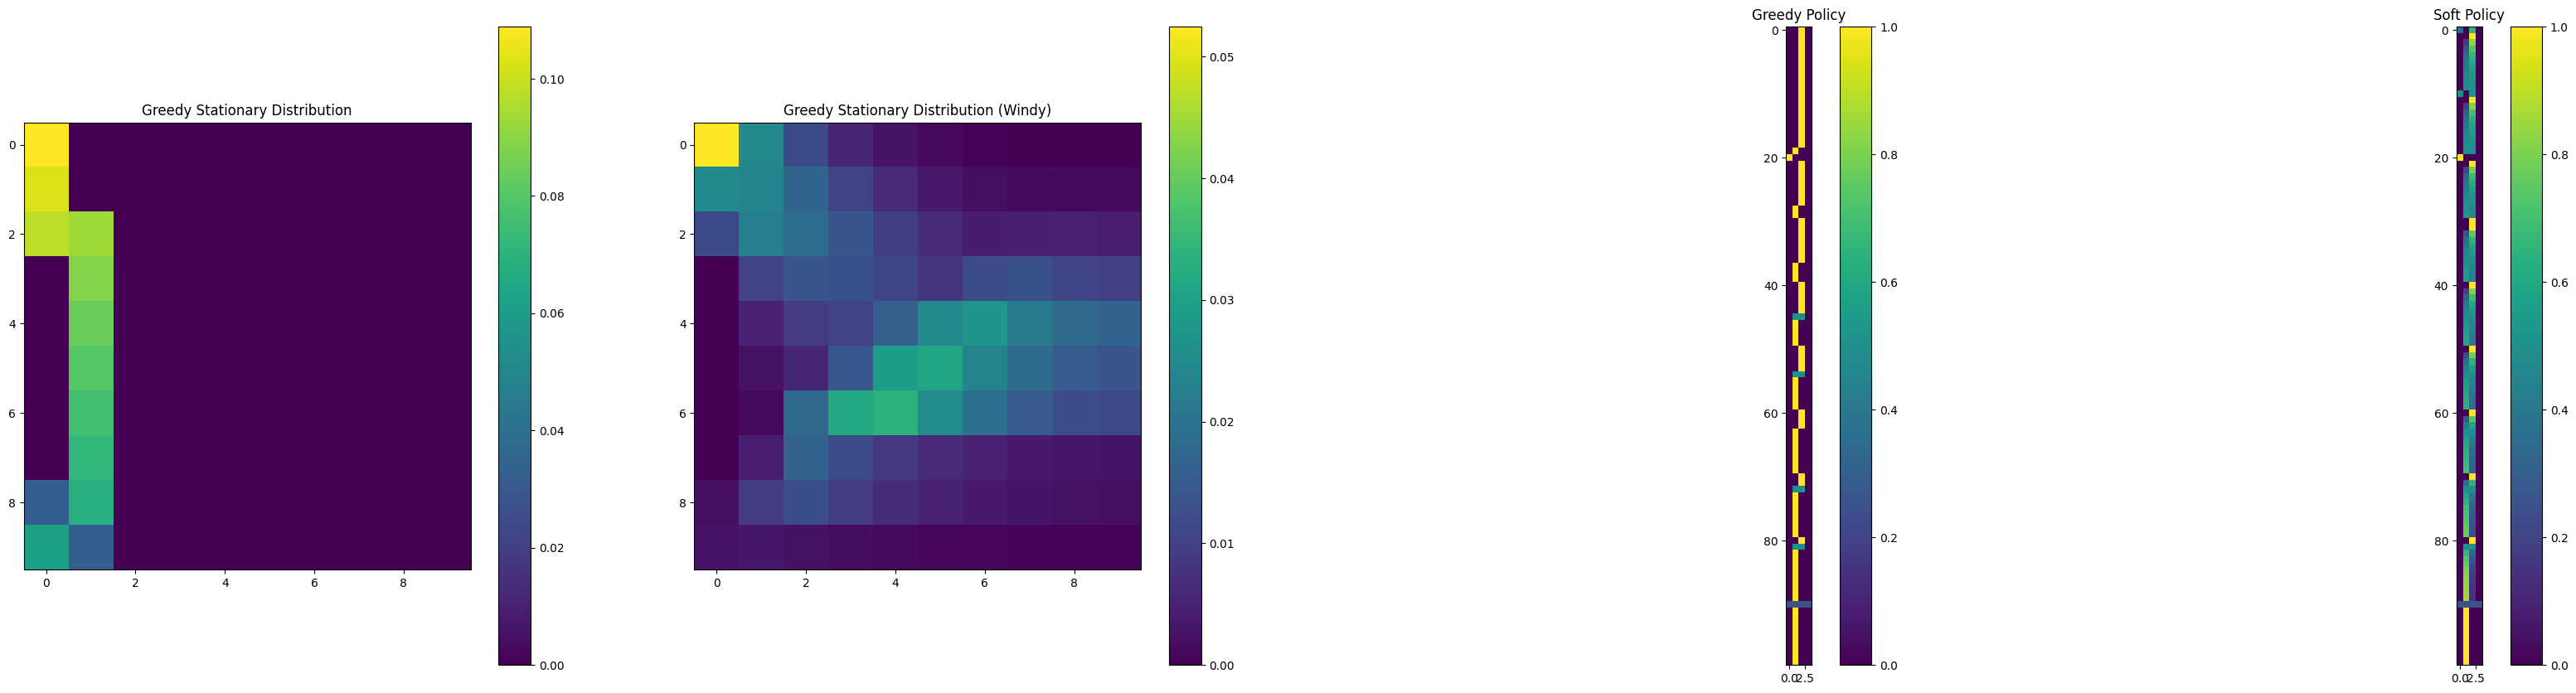

In [13]:
# @title Report results
greedy_pi = jnp.array(expert_pi == jnp.max(expert_pi, axis=1, keepdims=True)).astype(np.float32)
greedy_pi = greedy_pi / greedy_pi.sum(axis=1, keepdims=True)
greedy_rho = stationary_distribution(initial, transition_matrix, greedy_pi, discount)
windy_greedy_rho = stationary_distribution(initial, windy_transition_matrix, greedy_pi, discount)


pi_R_det = policy_eval(expert_pi, expert_rho)
pi_R_windy = policy_eval(expert_pi, expert_windy_rho)

greedy_R_det = policy_eval(greedy_pi, greedy_rho)
greedy_R_windy = policy_eval(greedy_pi, windy_greedy_rho)

bc_pi_R_det = policy_eval(bc_pi, bc_rho)
bc_pi_R_windy = policy_eval(bc_pi, bc_windy_rho)

meirl_pi_R_det = policy_eval(meirl_pi, meirl_rho)
meirl_pi_R_windy = policy_eval(meirl_pi, meirl_windy_rho)

gail_pi_R_det = policy_eval(gail_pi, gail_rho)
gail_pi_R_windy = policy_eval(gail_pi, gail_windy_rho)

csil_R_det = policy_eval(csil_pi, rho_pcirl)
csil_R_windy = policy_eval(csil_pi, windy_rho_pcirl)

irl_R_det = policy_eval(classifier_pi, classifier_rho)
irl_R_windy = policy_eval(classifier_pi, classifier_windy_rho)

iq_R_det = policy_eval(iq_pi, iq_rho)
iq_R_windy = policy_eval(iq_pi, iq_windy_rho)

ppil_R_det = policy_eval(ppil_pi, ppil_rho)
ppil_R_windy = policy_eval(ppil_pi, ppil_windy_rho)

data =  [["Greedy Soft Expert ", greedy_R_det, greedy_R_windy],
         ["Soft Expert ", pi_R_det, pi_R_windy],
         ["BC ", bc_pi_R_det, bc_pi_R_windy],
         ["CLASSIFIER ", irl_R_det, irl_R_windy],
         ["ME-IRL ", meirl_pi_R_det, meirl_pi_R_windy],
         ["GAIL ", gail_pi_R_det, gail_pi_R_windy],
         ["IQLEARN ", iq_R_det, iq_R_windy],
         ["PPIL ", ppil_R_det, ppil_R_windy],
         ["CSIL ", csil_R_det, csil_R_windy]]

table = tabulate.tabulate(data, tablefmt='html', floatfmt=".3f", headers=["","Deterministic","Windy"],)
display(HTML(table))

fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax_ = ax[0]
ax_.set_title("Greedy Stationary Distribution")
fig = ax_.imshow(greedy_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)
ax_ = ax[1]
ax_.set_title("Greedy Stationary Distribution (Windy)")
fig = ax_.imshow(windy_greedy_rho.reshape((width, width)))
plt.colorbar(fig, ax=ax_)
ax_ = ax[2]
ax_.set_title("Greedy Policy")
fig = ax_.imshow(greedy_pi)
plt.colorbar(fig, ax=ax_)
ax_ = ax[3]
ax_.set_title("Soft Policy")
fig = ax_.imshow(expert_pi)
plt.colorbar(fig, ax=ax_)

In [16]:
#@title Plotting imports and constants
import matplotlib
import matplotlib.pyplot as plt

base = 10
small_offset = 2
constrained_layout = True
tight_layout = True
_GOLDEN_RATIO = (5.0**0.5 - 1.0) / 2.0
width_in = 6.9
height_in = width_in
height_per_row = height_in // 4
pad_inches = 0.015
from matplotlib import rc
rc('mathtext', fontset='cm')

mpl_params = {
    'figure.constrained_layout.use': True,
    "lines.markersize": 0.1,
    "lines.linewidth": 1.0,
    "text.usetex": False,
    "mathtext.fontset": "stix",  # free ptmx replacement, for ICML and NeurIPS
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold",
    "font.size": base,
    "axes.labelsize": base,
    "legend.fontsize": base - small_offset,
    "xtick.labelsize": base - small_offset,
    "ytick.labelsize": base - small_offset,
    "axes.titlesize": base,
    "figure.constrained_layout.use": constrained_layout,
    "figure.autolayout": tight_layout,
    "savefig.bbox": "tight",
    "savefig.pad_inches": pad_inches,
}

plt.rcParams.update(mpl_params)

title_params = {'fontfamily':'monospace'}

YELLOW = '#F2E34C'
GREEN = '#82b392'
AQUA = '#41b6c4'
BLUE = '#2c7fb8'
ROYALBLUE = '#253494'
PURPLE = '#998ec3'

RED = '#d7191c'
LIGHTRED = '#ffcccb'
ORANGE = '#fdae61'
LIGHTBLUE = '#abd9e9'
MEDBLUE = '#2c7bb6'

LIGHTORANGE = '#fed98e'
MEDORANGE = '#fe9929'
DARKORANGE = '#cc4c02'

GREY = '#808080'

OPACITY = 0.2  # for uncertainty

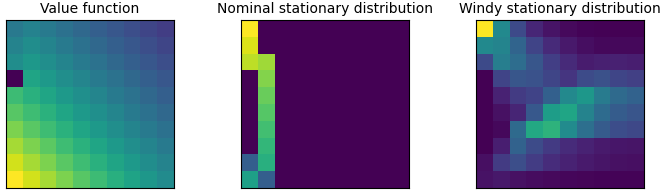

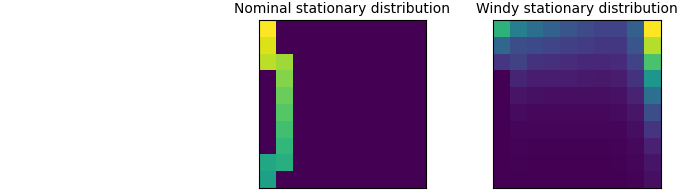

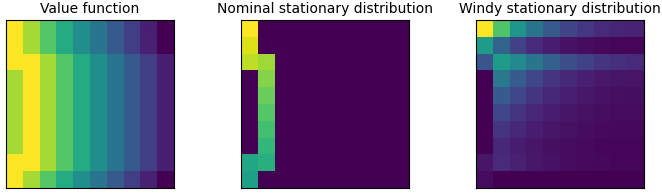

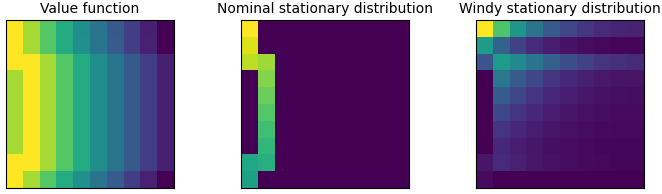

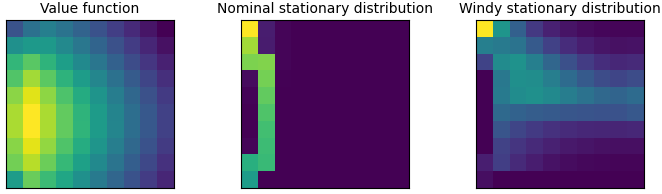

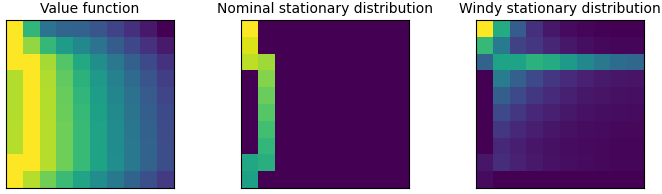

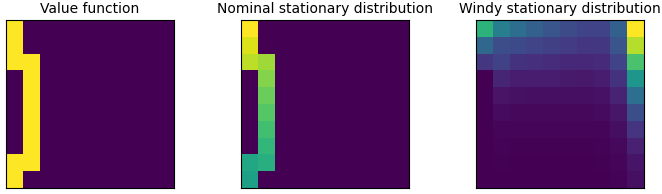

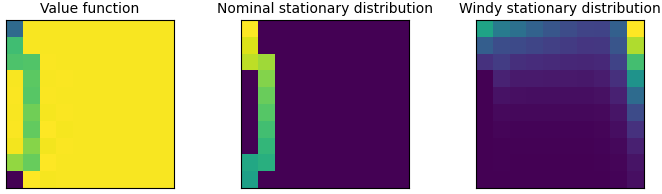

In [17]:
#@title Plot and save results
RESULTS = {
    "expert": (expert_v, greedy_rho, windy_greedy_rho),
    "bc": (None, bc_rho, bc_windy_rho),
    "csil": (csil_v, rho_pcirl, windy_rho_pcirl),
    "classifier": (classifier_v, classifier_rho, classifier_windy_rho),
    "me-irl": (meirl_v, meirl_rho, meirl_windy_rho),
    "gail": (gail_v, gail_rho, gail_windy_rho),
    "iqlearn": (iq_v, iq_rho, iq_windy_rho),
    "ppil": (ppil_v, ppil_rho, ppil_windy_rho),
}

exp = f"{'sparse' if SPARSE_INITIAL_STATES else 'dense'}_{'easy' if EASY_REWARD else 'hard'}"

for name, objs in RESULTS.items():
  fig, ax = plt.subplots(1, 3, figsize=(width_in, width_in // 3), sharex=True, sharey=True, gridspec_kw={'wspace': 0.1})
  for ax_ in ax:
    ax_.set_xticklabels([])
    ax_.set_yticklabels([])
    ax_.set_xticks([])
    ax_.set_yticks([])
  v, rho, wrho = objs

  ax_ = ax[0]
  if v is not None:
    ax_.set_title("Value function")
    ax_.imshow(v.reshape((width, width)))
  else:
    ax_.axis('off')

  ax_ = ax[1]
  ax_.set_title("Nominal stationary distribution")
  ax_.imshow(rho.reshape((width, width)))
  ax_ = ax[2]
  ax_.set_title("Windy stationary distribution")
  ax_.imshow(wrho.reshape((width, width)))